# Exploratory Data Analysis (EDA)

## Highlights

### Outlier detection and cleaning
  - After narrowing the scope to only Social channels, most extreme outliers were dropped instantaneously
  - Z score method - omitted (got rid of all rows)
  - IQR method - omitted (got rid of all rows early on in the weeks)
  - Reasonable maximum was used to remove remaining outliers
    - CVR(BF) $\le$ 1250
    - CVR(S) $\le$ 75


### Primary learning objectives

**<ins>Optimal mix of creatives per funnel + publisher</ins>**

Creatives grouped by these key attributes: publisher, lob, product, kpi_audience

Top 10 most common upper funnel creative elements maximizing average CTR.

<img src="Figures/ctr_top10.png">

The top 10 most common middle funnel creative elements maximizing average site visit CVR.

<img src="Figures/sv_top10.png">

The top 10 most common middle funnel creative elements maximizing average buy flow entry CVR.

<img src="Figures/bf_top10.png">

The top 10 most common lower funnel creative elements maximizing average sales CVR.

<img src="Figures/cvrs_top10.png">


**<ins>Impact of number of creatives in market on performance</ins>**

Time series regression was utilized to find the relationship between number of creatives in market and performance.

Estimation equations are ***not*** causal.

$\Delta MedCTR^{UF}_t = -0.005 - (0.0004)\Delta InMarket^{UF}_t + (0.043)Holiday_t$

$\Delta MedCVRSV^{MF}_t = -0.006 + (0.0004)\Delta InMarket^{MF}_t$

$\Delta MedCVRBF^{MF}_t = -1.18 - (0.071)\Delta InMarket^{MF}_t + (8.24)Holiday_t$

$\Delta MedCVRS^{LF}_t = 0.01 - (0.012)\Delta InMarket^{LF}_t$

- CTR: On average, adding one more upper funnel creatives has almost no effect (~ -0.0004) on median CTR, all else constant.
- CVR(SV): On average, adding one more middle funnel creatives has almost no effect (~ 0.0004) on median SV CVR, all else constant.
- CVR(BF): On average, adding one more middle funnel creative relates to a median BF CVR decrease of 0.071 percent, all else constant.
- CVR(S): On average, adding one more lower funnel creatives relates to a median Sales CVR decrease of 0.012 percent, all else constant.

### Secondary Learning Outcomes

**<ins>Additional data points to capture</ins>**

See end of section PLO - Optimal mix of creatives per funnel + publisher.

### Additional analysis

**<ins>What's the average KPI behaviour after launch?</ins>**

<img src="Figures/aa1.png">

CTRs fall immediately upon launch, whereas BF, SV, and sales increases for a short period. This behaviour seems normal since some people may visit the website but not necessarily by clicking on the creative ad itself. We also see that a creatives life cycle begins to end near week 10 where the "elbow" or "kink" is located.

**<ins>What's the behavioral average KPI response on spending and in market creatives?</ins>**

- Upper funnel creatives served in publisher 4 yield greater CTRs than creatives served in publisher 3. There seems to be some ROI from money spent on publisher 4, but money spent on creatives in publisher 3 seem to have no affect on CTRs
- Middle funnel creatives served in publisher 3 yield higher site visit conversion rates than creatives served in publisher 4. Publisher 4 creatives seem to have low ROI compared to publisher 3 creatives
- Middle funnel creatives served in publisher 4 yield higher buy flow conversion rates than creatives served in publisher 3. It's difficult to tell if money spent has any affect since publisher 3 and 4 creatives follow a similar CVR pattern
- Lower funnel creatives served in publisher 3 yield higher buy flow entry CVRs than creatives served in publisher 4. Comparing spending and CVRs before January 31, 2021, it seems that spending has no affect on buy flow CVRs
- Lower funnel creatives served in publisher 3 yield higher sales conversion rates than creatives served in publisher 4. Again, comparing spending and CVRs before January 31, 2021, it seems that spending has no affect on sales CVRs

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import holidays
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

import warnings

# Set graph style
sns.set()

pd.options.display.max_columns = None
warnings.filterwarnings('ignore')

%matplotlib inline

In [51]:
data = pd.read_csv('C:/Users/saulc/OneDrive - University of Calgary/Classes/Econ 599 - OneDrive/KPI Project Data 0120_1221.csv')
labeled_data = pd.read_csv('C:/Users/saulc/OneDrive - University of Calgary/Classes/Econ 599 - OneDrive/labeled_data.csv')

In [52]:
# Focus only on Social channel
social_data = data[data.channel == 'Social'].drop(columns=['channel', 'size'])
labeled_social_data = labeled_data[labeled_data.channel == 1].drop(columns=['channel', 'size'])
print(f'Number of creative observations dropped: {len(data) - len(social_data)}')

Number of creative observations dropped: 10819


In [53]:
print(social_data.shape)
social_data.head()

(2452, 628)


,Creative ID,funnel,publisher,lob,product,theme,kpi_audience,creative_versions,price,price_placement,discount,offer_placement,offer_group,asset_type,video_type,length,2019-12-30-Spend,2020-1-6-Spend,2020-1-13-Spend,2020-1-20-Spend,2020-1-27-Spend,2020-2-3-Spend,2020-2-10-Spend,2020-2-17-Spend,2020-2-24-Spend,2020-3-2-Spend,2020-3-9-Spend,2020-3-16-Spend,2020-4-13-Spend,2020-4-20-Spend,2020-4-27-Spend,2020-5-4-Spend,2020-5-11-Spend,2020-5-18-Spend,2020-5-25-Spend,2020-6-1-Spend,2020-6-8-Spend,2020-6-15-Spend,2020-6-22-Spend,2020-6-29-Spend,2020-7-6-Spend,2020-7-13-Spend,2020-7-20-Spend,2020-7-27-Spend,2020-8-3-Spend,2020-8-10-Spend,2020-8-17-Spend,2020-8-24-Spend,2020-8-31-Spend,2020-9-7-Spend,2020-9-14-Spend,2020-9-21-Spend,2020-9-28-Spend,2020-10-5-Spend,2020-10-12-Spend,2020-10-19-Spend,2020-10-26-Spend,2020-11-2-Spend,2020-11-9-Spend,2020-11-16-Spend,2020-11-23-Spend,2020-11-30-Spend,2020-12-7-Spend,2020-12-14-Spend,2020-12-21-Spend,2020-12-28-Spend,2021-1-4-Spend,2021-1-11-Spend,2021-1-18-Spend,2021-1-25-Spend,2021-2-1-Spend,2021-2-8-Spend,2021-2-15-Spend,2021-2-22-Spend,2021-3-1-Spend,2021-3-8-Spend,2021-3-15-Spend,2021-3-22-Spend,2021-3-29-Spend,2021-4-5-Spend,2021-4-12-Spend,2021-4-19-Spend,2021-4-26-Spend,2021-5-3-Spend,2021-5-10-Spend,2021-5-17-Spend,2021-5-24-Spend,2021-5-31-Spend,2021-6-7-Spend,2021-6-14-Spend,2021-6-21-Spend,2021-6-28-Spend,2021-7-5-Spend,2021-7-12-Spend,2021-7-19-Spend,2021-7-26-Spend,2021-8-2-Spend,2021-8-9-Spend,2021-8-16-Spend,2021-8-23-Spend,2021-8-30-Spend,2021-9-6-Spend,2021-9-13-Spend,2021-9-20-Spend,2021-9-27-Spend,2021-10-4-Spend,2021-10-11-Spend,2021-10-18-Spend,2021-10-25-Spend,2021-11-1-Spend,2021-11-8-Spend,2021-11-15-Spend,2021-11-22-Spend,2021-11-29-Spend,2021-12-6-Spend,2021-12-13-Spend,2021-12-20-Spend,2021-12-27-Spend,2019-12-30-Impressions,2020-1-6-Impressions,2020-1-13-Impressions,2020-1-20-Impressions,2020-1-27-Impressions,2020-2-3-Impressions,2020-2-10-Impressions,2020-2-17-Impressions,2020-2-24-Impressions,2020-3-2-Impressions,2020-3-9-Impressions,2020-3-16-Impressions,2020-4-13-Impressions,2020-4-20-Impressions,2020-4-27-Impressions,2020-5-4-Impressions,2020-5-11-Impressions,2020-5-18-Impressions,2020-5-25-Impressions,2020-6-1-Impressions,2020-6-8-Impressions,2020-6-15-Impressions,2020-6-22-Impressions,2020-6-29-Impressions,2020-7-6-Impressions,2020-7-13-Impressions,2020-7-20-Impressions,2020-7-27-Impressions,2020-8-3-Impressions,2020-8-10-Impressions,2020-8-17-Impressions,2020-8-24-Impressions,2020-8-31-Impressions,2020-9-7-Impressions,2020-9-14-Impressions,2020-9-21-Impressions,2020-9-28-Impressions,2020-10-5-Impressions,2020-10-12-Impressions,2020-10-19-Impressions,2020-10-26-Impressions,2020-11-2-Impressions,2020-11-9-Impressions,2020-11-16-Impressions,2020-11-23-Impressions,2020-11-30-Impressions,2020-12-7-Impressions,2020-12-14-Impressions,2020-12-21-Impressions,2020-12-28-Impressions,2021-1-4-Impressions,2021-1-11-Impressions,2021-1-18-Impressions,2021-1-25-Impressions,2021-2-1-Impressions,2021-2-8-Impressions,2021-2-15-Impressions,2021-2-22-Impressions,2021-3-1-Impressions,2021-3-8-Impressions,2021-3-15-Impressions,2021-3-22-Impressions,2021-3-29-Impressions,2021-4-5-Impressions,2021-4-12-Impressions,2021-4-19-Impressions,2021-4-26-Impressions,2021-5-3-Impressions,2021-5-10-Impressions,2021-5-17-Impressions,2021-5-24-Impressions,2021-5-31-Impressions,2021-6-7-Impressions,2021-6-14-Impressions,2021-6-21-Impressions,2021-6-28-Impressions,2021-7-5-Impressions,2021-7-12-Impressions,2021-7-19-Impressions,2021-7-26-Impressions,2021-8-2-Impressions,2021-8-9-Impressions,2021-8-16-Impressions,2021-8-23-Impressions,2021-8-30-Impressions,2021-9-6-Impressions,2021-9-13-Impressions,2021-9-20-Impressions,2021-9-27-Impressions,2021-10-4-Impressions,2021-10-11-Impressions,2021-10-18-Impressions,2021-10-25-Impressions,2021-11-1-Impressions,2021-11-8-Impressions,2021-11-15-Impressions,2021-11-22-Impressions,2021-11-29-Impressions,2021-12-6-Impressions,2021-12-13-Impressions,2021-12-2

In [54]:
labeled_social_data.head()

,Creative ID,funnel,publisher,lob,product,theme,kpi_audience,creative_versions,price,price_placement,discount,offer_placement,offer_group,asset_type,video_type,length,Mean_Spend,total_spend,total_Impressions,Mean_CTR,Mean_CVRS,Mean_CVRBF,Mean_CVRSV,Peak_CTR,Peak_CVRS,Peak_CVRBF,Peak_CVRSV,Med_CTR,Med_CVRS,Med_CVRBF,Med_CVRSV,CTR_W0,CTR_W1,CTR_W2,CTR_W3,CTR_W4,CTR_W5,CTR_W6,CTR_W7,CTR_W8,CTR_W9,CTR_W10,CTR_W11,CTR_W12,CTR_W13,CTR_W14,CTR_W15,CTR_W16,CTR_W17,CTR_W18,CTR_W19,CTR_W20,CTR_W21,CTR_W22,CTR_W23,CTR_W24,CTR_W25,CTR_W26,CTR_W27,CTR_W28,CTR_W29,CTR_W30,CTR_W31,CTR_W32,CTR_W33,CTR_W34,CTR_W35,CTR_W36,CTR_W37,CTR_W38,CTR_W39,CTR_W40,CTR_W41,CTR_W42,CTR_W43,CTR_W44,CTR_W45,CTR_W46,CTR_W47,CVR(BF)_W0,CVR(BF)_W1,CVR(BF)_W2,CVR(BF)_W3,CVR(BF)_W4,CVR(BF)_W5,CVR(BF)_W6,CVR(BF)_W7,CVR(BF)_W8,CVR(BF)_W9,CVR(BF)_W10,CVR(BF)_W11,CVR(BF)_W12,CVR(BF)_W13,CVR(BF)_W14,CVR(BF)_W15,CVR(BF)_W16,CVR(BF)_W17,CVR(BF)_W18,CVR(BF)_W19,CVR(BF)_W20,CVR(BF)_W21,CVR(BF)_W22,CVR(BF)_W23,CVR(BF)_W24,CVR(BF)_W25,CVR(BF)_W26,CVR(BF)_W27,CVR(BF)_W28,CVR(BF)_W29,CVR(BF)_W30,CVR(BF)_W31,CVR(BF)_W32,CVR(BF)_W33,CVR(BF)_W34,CVR(BF)_W35,CVR(BF)_W36,CVR(BF)_W37,CVR(BF)_W38,CVR(BF)_W39,CVR(BF)_W40,CVR(BF)_W41,CVR(BF)_W42,CVR(BF)_W43,CVR(BF)_W44,CVR(BF)_W45,CVR(BF)_W46,CVR(BF)_W47,CVR(SV)_W0,CVR(SV)_W1,CVR(SV)_W2,CVR(SV)_W3,CVR(SV)_W4,CVR(SV)_W5,CVR(SV)_W6,CVR(SV)_W7,CVR(SV)_W8,CVR(SV)_W9,CVR(SV)_W10,CVR(SV)_W11,CVR(SV)_W12,CVR(SV)_W13,CVR(SV)_W14,CVR(SV)_W15,CVR(SV)_W16,CVR(SV)_W17,CVR(SV)_W18,CVR(SV)_W19,CVR(SV)_W20,CVR(SV)_W21,CVR(SV)_W22,CVR(SV)_W23,CVR(SV)_W24,CVR(SV)_W25,CVR(SV)_W26,CVR(SV)_W27,CVR(SV)_W28,CVR(SV)_W29,CVR(SV)_W30,CVR(SV)_W31,CVR(SV)_W32,CVR(SV)_W33,CVR(SV)_W34,CVR(SV)_W35,CVR(SV)_W36,CVR(SV)_W37,CVR(SV)_W38,CVR(SV)_W39,CVR(SV)_W40,CVR(SV)_W41,CVR(SV)_W42,CVR(SV)_W43,CVR(SV)_W44,CVR(SV)_W45,CVR(SV)_W46,CVR(SV)_W47,Internet_CVR(S)_W0,Internet_CVR(S)_W1,Internet_CVR(S)_W2,Internet_CVR(S)_W3,Internet_CVR(S)_W4,Internet_CVR(S)_W5,Internet_CVR(S)_W6,Internet_CVR(S)_W7,Internet_CVR(S)_W8,Internet_CVR(S)_W9,Internet_CVR(S)_W10,Internet_CVR(S)_W11,Internet_CVR(S)_W12,Internet_CVR(S)_W13,Internet_CVR(S)_W14,Internet_CVR(S)_W15,Internet_CVR(S)_W16,Internet_CVR(S)_W17,Internet_CVR(S)_W18,Internet_CVR(S)_W19,Internet_CVR(S)_W20,Internet_CVR(S)_W21,Internet_CVR(S)_W22,Internet_CVR(S)_W23,Internet_CVR(S)_W24,Internet_CVR(S)_W25,Internet_CVR(S)_W26,Internet_CVR(S)_W27,Internet_CVR(S)_W28,Internet_CVR(S)_W29,Internet_CVR(S)_W30,Internet_CVR(S)_W31,Internet_CVR(S)_W32,Internet_CVR(S)_W33,Internet_CVR(S)_W34,Internet_CVR(S)_W35,Internet_CVR(S)_W36,Internet_CVR(S)_W37,Internet_CVR(S)_W38,Internet_CVR(S)_W39,Internet_CVR(S)_W40,Internet_CVR(S)_W41,Internet_CVR(S)_W42,Internet_CVR(S)_W43,Internet_CVR(S)_W44,Internet_CVR(S)_W45,Internet_CVR(S)_W46,Internet_CVR(S)_W47,Impressions_W0,Impressions_W1,Impressions_W2,Impressions_W3,Impressions_W4,Impressions_W5,Impressions_W6,Impressions_W7,Impressions_W8,Impressions_W9,Impressions_W10,Impressions_W11,Impressions_W12,Impressions_W13,Impressions_W14,Impressions_W15,Impressions_W16,Impressions_W17,Impressions_W18,Impressions_W19,Impressions_W20,Impressions_W21,Impressions_W22,Impressions_W23,Impressions_W24,Impressions_W25,Impressions_W26,Impressions_W27,Impressions_W28,Impressions_W29,Impressions_W30,Impressions_W31,Impressions_W32,Impressions_W33,Impressions_W34,Impressions_W35,Impressions_W36,Impressions_W37,Impressions_W38,Impressions_W39,Impressions_W40,Impressions_W41,Impressions_W42,Impressions_W43,Impressions_W44,Impressions_W45,Impressions_W46,Impressions_W47,Spend_W0,Spend_W1,Spend_W2,Spend_W3,Spend_W4,Spend_W5,Spend_W6,Spend_W7,Spend_W8,Spend_W9,Spend_W10,Spend_W11,Spend_W12,Spend_W13,Spend_W14,Spend_W15,Spend_W16,Spend_W17,Spend_W18,Spend_W19,Spend_W20,Spend_W21,Spend_W22,Spend_W23,Spend_W24,Spend_W25,Spend_W26,Spend_W27,Spend_W28,Spend_W29,Spend_W30,Spend_W31,Spend_W32,Spend_W33,Spend_W34,Spend_W35,Spend_W36,Spend_W37,Spend_W38,Spend_W39,Spend_W40,Spend_W41,Spend_W42,Spend_W43,Spend_W44,Spend_W45,Spend_W46

In [55]:
# Explore variables and week variables seperately
social_data = social_data.iloc[:, :16]
week_data = labeled_social_data.iloc[:, 31:]

## Outlier Detection and Cleaning

### Week variables

In [56]:
week_data.head()

,CTR_W0,CTR_W1,CTR_W2,CTR_W3,CTR_W4,CTR_W5,CTR_W6,CTR_W7,CTR_W8,CTR_W9,CTR_W10,CTR_W11,CTR_W12,CTR_W13,CTR_W14,CTR_W15,CTR_W16,CTR_W17,CTR_W18,CTR_W19,CTR_W20,CTR_W21,CTR_W22,CTR_W23,CTR_W24,CTR_W25,CTR_W26,CTR_W27,CTR_W28,CTR_W29,CTR_W30,CTR_W31,CTR_W32,CTR_W33,CTR_W34,CTR_W35,CTR_W36,CTR_W37,CTR_W38,CTR_W39,CTR_W40,CTR_W41,CTR_W42,CTR_W43,CTR_W44,CTR_W45,CTR_W46,CTR_W47,CVR(BF)_W0,CVR(BF)_W1,CVR(BF)_W2,CVR(BF)_W3,CVR(BF)_W4,CVR(BF)_W5,CVR(BF)_W6,CVR(BF)_W7,CVR(BF)_W8,CVR(BF)_W9,CVR(BF)_W10,CVR(BF)_W11,CVR(BF)_W12,CVR(BF)_W13,CVR(BF)_W14,CVR(BF)_W15,CVR(BF)_W16,CVR(BF)_W17,CVR(BF)_W18,CVR(BF)_W19,CVR(BF)_W20,CVR(BF)_W21,CVR(BF)_W22,CVR(BF)_W23,CVR(BF)_W24,CVR(BF)_W25,CVR(BF)_W26,CVR(BF)_W27,CVR(BF)_W28,CVR(BF)_W29,CVR(BF)_W30,CVR(BF)_W31,CVR(BF)_W32,CVR(BF)_W33,CVR(BF)_W34,CVR(BF)_W35,CVR(BF)_W36,CVR(BF)_W37,CVR(BF)_W38,CVR(BF)_W39,CVR(BF)_W40,CVR(BF)_W41,CVR(BF)_W42,CVR(BF)_W43,CVR(BF)_W44,CVR(BF)_W45,CVR(BF)_W46,CVR(BF)_W47,CVR(SV)_W0,CVR(SV)_W1,CVR(SV)_W2,CVR(SV)_W3,CVR(SV)_W4,CVR(SV)_W5,CVR(SV)_W6,CVR(SV)_W7,CVR(SV)_W8,CVR(SV)_W9,CVR(SV)_W10,CVR(SV)_W11,CVR(SV)_W12,CVR(SV)_W13,CVR(SV)_W14,CVR(SV)_W15,CVR(SV)_W16,CVR(SV)_W17,CVR(SV)_W18,CVR(SV)_W19,CVR(SV)_W20,CVR(SV)_W21,CVR(SV)_W22,CVR(SV)_W23,CVR(SV)_W24,CVR(SV)_W25,CVR(SV)_W26,CVR(SV)_W27,CVR(SV)_W28,CVR(SV)_W29,CVR(SV)_W30,CVR(SV)_W31,CVR(SV)_W32,CVR(SV)_W33,CVR(SV)_W34,CVR(SV)_W35,CVR(SV)_W36,CVR(SV)_W37,CVR(SV)_W38,CVR(SV)_W39,CVR(SV)_W40,CVR(SV)_W41,CVR(SV)_W42,CVR(SV)_W43,CVR(SV)_W44,CVR(SV)_W45,CVR(SV)_W46,CVR(SV)_W47,Internet_CVR(S)_W0,Internet_CVR(S)_W1,Internet_CVR(S)_W2,Internet_CVR(S)_W3,Internet_CVR(S)_W4,Internet_CVR(S)_W5,Internet_CVR(S)_W6,Internet_CVR(S)_W7,Internet_CVR(S)_W8,Internet_CVR(S)_W9,Internet_CVR(S)_W10,Internet_CVR(S)_W11,Internet_CVR(S)_W12,Internet_CVR(S)_W13,Internet_CVR(S)_W14,Internet_CVR(S)_W15,Internet_CVR(S)_W16,Internet_CVR(S)_W17,Internet_CVR(S)_W18,Internet_CVR(S)_W19,Internet_CVR(S)_W20,Internet_CVR(S)_W21,Internet_CVR(S)_W22,Internet_CVR(S)_W23,Internet_CVR(S)_W24,Internet_CVR(S)_W25,Internet_CVR(S)_W26,Internet_CVR(S)_W27,Internet_CVR(S)_W28,Internet_CVR(S)_W29,Internet_CVR(S)_W30,Internet_CVR(S)_W31,Internet_CVR(S)_W32,Internet_CVR(S)_W33,Internet_CVR(S)_W34,Internet_CVR(S)_W35,Internet_CVR(S)_W36,Internet_CVR(S)_W37,Internet_CVR(S)_W38,Internet_CVR(S)_W39,Internet_CVR(S)_W40,Internet_CVR(S)_W41,Internet_CVR(S)_W42,Internet_CVR(S)_W43,Internet_CVR(S)_W44,Internet_CVR(S)_W45,Internet_CVR(S)_W46,Internet_CVR(S)_W47,Impressions_W0,Impressions_W1,Impressions_W2,Impressions_W3,Impressions_W4,Impressions_W5,Impressions_W6,Impressions_W7,Impressions_W8,Impressions_W9,Impressions_W10,Impressions_W11,Impressions_W12,Impressions_W13,Impressions_W14,Impressions_W15,Impressions_W16,Impressions_W17,Impressions_W18,Impressions_W19,Impressions_W20,Impressions_W21,Impressions_W22,Impressions_W23,Impressions_W24,Impressions_W25,Impressions_W26,Impressions_W27,Impressions_W28,Impressions_W29,Impressions_W30,Impressions_W31,Impressions_W32,Impressions_W33,Impressions_W34,Impressions_W35,Impressions_W36,Impressions_W37,Impressions_W38,Impressions_W39,Impressions_W40,Impressions_W41,Impressions_W42,Impressions_W43,Impressions_W44,Impressions_W45,Impressions_W46,Impressions_W47,Spend_W0,Spend_W1,Spend_W2,Spend_W3,Spend_W4,Spend_W5,Spend_W6,Spend_W7,Spend_W8,Spend_W9,Spend_W10,Spend_W11,Spend_W12,Spend_W13,Spend_W14,Spend_W15,Spend_W16,Spend_W17,Spend_W18,Spend_W19,Spend_W20,Spend_W21,Spend_W22,Spend_W23,Spend_W24,Spend_W25,Spend_W26,Spend_W27,Spend_W28,Spend_W29,Spend_W30,Spend_W31,Spend_W32,Spend_W33,Spend_W34,Spend_W35,Spend_W36,Spend_W37,Spend_W38,Spend_W39,Spend_W40,Spend_W41,Spend_W42,Spend_W43,Spend_W44,Spend_W45,Spend_W46,Spend_W47
0,0.98,1.58,0.00,0.00,0.13,0.43,0.48,0.43,0.41,0.9,1.71,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [57]:
week_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2452 entries, 0 to 13216
Columns: 288 entries, CTR_W0 to Spend_W47
dtypes: float64(288)
memory usage: 5.4 MB


In [58]:
week_data.describe()

,CTR_W0,CTR_W1,CTR_W2,CTR_W3,CTR_W4,CTR_W5,CTR_W6,CTR_W7,CTR_W8,CTR_W9,CTR_W10,CTR_W11,CTR_W12,CTR_W13,CTR_W14,CTR_W15,CTR_W16,CTR_W17,CTR_W18,CTR_W19,CTR_W20,CTR_W21,CTR_W22,CTR_W23,CTR_W24,CTR_W25,CTR_W26,CTR_W27,CTR_W28,CTR_W29,CTR_W30,CTR_W31,CTR_W32,CTR_W33,CTR_W34,CTR_W35,CTR_W36,CTR_W37,CTR_W38,CTR_W39,CTR_W40,CTR_W41,CTR_W42,CTR_W43,CTR_W44,CTR_W45,CTR_W46,CTR_W47,CVR(BF)_W0,CVR(BF)_W1,CVR(BF)_W2,CVR(BF)_W3,CVR(BF)_W4,CVR(BF)_W5,CVR(BF)_W6,CVR(BF)_W7,CVR(BF)_W8,CVR(BF)_W9,CVR(BF)_W10,CVR(BF)_W11,CVR(BF)_W12,CVR(BF)_W13,CVR(BF)_W14,CVR(BF)_W15,CVR(BF)_W16,CVR(BF)_W17,CVR(BF)_W18,CVR(BF)_W19,CVR(BF)_W20,CVR(BF)_W21,CVR(BF)_W22,CVR(BF)_W23,CVR(BF)_W24,CVR(BF)_W25,CVR(BF)_W26,CVR(BF)_W27,CVR(BF)_W28,CVR(BF)_W29,CVR(BF)_W30,CVR(BF)_W31,CVR(BF)_W32,CVR(BF)_W33,CVR(BF)_W34,CVR(BF)_W35,CVR(BF)_W36,CVR(BF)_W37,CVR(BF)_W38,CVR(BF)_W39,CVR(BF)_W40,CVR(BF)_W41,CVR(BF)_W42,CVR(BF)_W43,CVR(BF)_W44,CVR(BF)_W45,CVR(BF)_W46,CVR(BF)_W47,CVR(SV)_W0,CVR(SV)_W1,CVR(SV)_W2,CVR(SV)_W3,CVR(SV)_W4,CVR(SV)_W5,CVR(SV)_W6,CVR(SV)_W7,CVR(SV)_W8,CVR(SV)_W9,CVR(SV)_W10,CVR(SV)_W11,CVR(SV)_W12,CVR(SV)_W13,CVR(SV)_W14,CVR(SV)_W15,CVR(SV)_W16,CVR(SV)_W17,CVR(SV)_W18,CVR(SV)_W19,CVR(SV)_W20,CVR(SV)_W21,CVR(SV)_W22,CVR(SV)_W23,CVR(SV)_W24,CVR(SV)_W25,CVR(SV)_W26,CVR(SV)_W27,CVR(SV)_W28,CVR(SV)_W29,CVR(SV)_W30,CVR(SV)_W31,CVR(SV)_W32,CVR(SV)_W33,CVR(SV)_W34,CVR(SV)_W35,CVR(SV)_W36,CVR(SV)_W37,CVR(SV)_W38,CVR(SV)_W39,CVR(SV)_W40,CVR(SV)_W41,CVR(SV)_W42,CVR(SV)_W43,CVR(SV)_W44,CVR(SV)_W45,CVR(SV)_W46,CVR(SV)_W47,Internet_CVR(S)_W0,Internet_CVR(S)_W1,Internet_CVR(S)_W2,Internet_CVR(S)_W3,Internet_CVR(S)_W4,Internet_CVR(S)_W5,Internet_CVR(S)_W6,Internet_CVR(S)_W7,Internet_CVR(S)_W8,Internet_CVR(S)_W9,Internet_CVR(S)_W10,Internet_CVR(S)_W11,Internet_CVR(S)_W12,Internet_CVR(S)_W13,Internet_CVR(S)_W14,Internet_CVR(S)_W15,Internet_CVR(S)_W16,Internet_CVR(S)_W17,Internet_CVR(S)_W18,Internet_CVR(S)_W19,Internet_CVR(S)_W20,Internet_CVR(S)_W21,Internet_CVR(S)_W22,Internet_CVR(S)_W23,Internet_CVR(S)_W24,Internet_CVR(S)_W25,Internet_CVR(S)_W26,Internet_CVR(S)_W27,Internet_CVR(S)_W28,Internet_CVR(S)_W29,Internet_CVR(S)_W30,Internet_CVR(S)_W31,Internet_CVR(S)_W32,Internet_CVR(S)_W33,Internet_CVR(S)_W34,Internet_CVR(S)_W35,Internet_CVR(S)_W36,Internet_CVR(S)_W37,Internet_CVR(S)_W38,Internet_CVR(S)_W39,Internet_CVR(S)_W40,Internet_CVR(S)_W41,Internet_CVR(S)_W42,Internet_CVR(S)_W43,Internet_CVR(S)_W44,Internet_CVR(S)_W45,Internet_CVR(S)_W46,Internet_CVR(S)_W47,Impressions_W0,Impressions_W1,Impressions_W2,Impressions_W3,Impressions_W4,Impressions_W5,Impressions_W6,Impressions_W7,Impressions_W8,Impressions_W9,Impressions_W10,Impressions_W11,Impressions_W12,Impressions_W13,Impressions_W14,Impressions_W15,Impressions_W16,Impressions_W17,Impressions_W18,Impressions_W19,Impressions_W20,Impressions_W21,Impressions_W22,Impressions_W23,Impressions_W24,Impressions_W25,Impressions_W26,Impressions_W27,Impressions_W28,Impressions_W29,Impressions_W30,Impressions_W31,Impressions_W32,Impressions_W33,Impressions_W34,Impressions_W35,Impressions_W36,Impressions_W37,Impressions_W38,Impressions_W39,Impressions_W40,Impressions_W41,Impressions_W42,Impressions_W43,Impressions_W44,Impressions_W45,Impressions_W46,Impressions_W47,Spend_W0,Spend_W1,Spend_W2,Spend_W3,Spend_W4,Spend_W5,Spend_W6,Spend_W7,Spend_W8,Spend_W9,Spend_W10,Spend_W11,Spend_W12,Spend_W13,Spend_W14,Spend_W15,Spend_W16,Spend_W17,Spend_W18,Spend_W19,Spend_W20,Spend_W21,Spend_W22,Spend_W23,Spend_W24,Spend_W25,Spend_W26,Spend_W27,Spend_W28,Spend_W29,Spend_W30,Spend_W31,Spend_W32,Spend_W33,Spend_W34,Spend_W35,Spend_W36,Spend_W37,Spend_W38,Spend_W39,Spend_W40,Spend_W41,Spend_W42,Spend_W43,Spend_W44,Spend_W45,Spend_W46,Spend_W47
count,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.00000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.00000,2452.000000,2452.000000,2452.000000

Weeks 41 to 47 originally contained data but now with the removal of the display channel no longer. The same goes for impressions and spending. Additionally, `CVR(BF)` has much larger maximums relative to the other KPI rates.

In [59]:
# Remove W41 to W47
weeks_to_drop = [f'W{i}' for i in range(41, 48)]
for week in week_data.columns:
    if week[-3:] in weeks_to_drop:
        week_data.drop(columns=week, inplace=True)

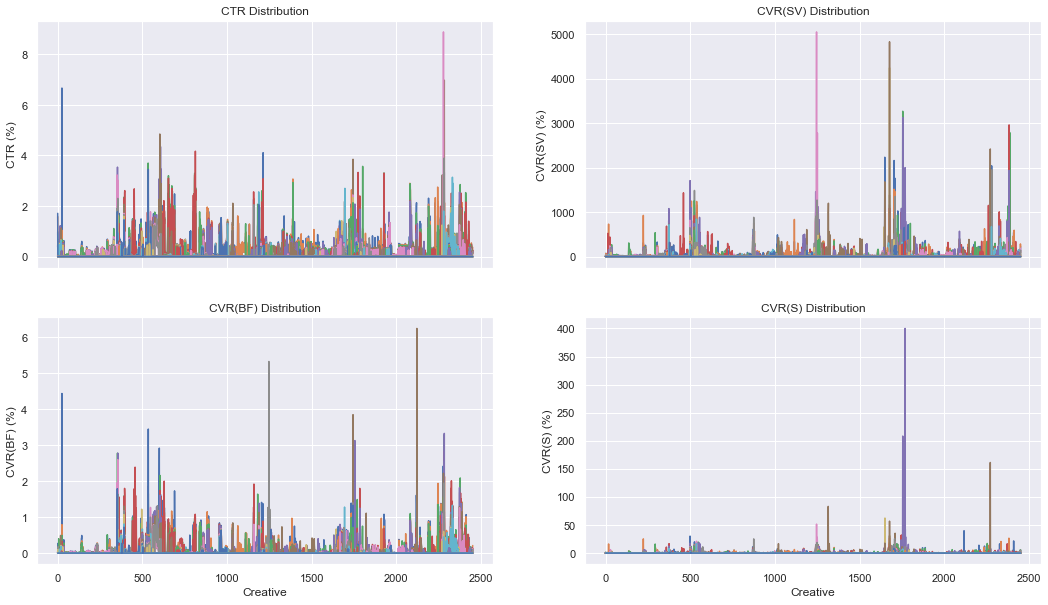

In [60]:
ctr_w = [f'CTR_W{i}' for i in range(41)]
cvrbf_w = [f'CVR(BF)_W{i}' for i in range(41)]
cvrsv_w = [f'CVR(SV)_W{i}' for i in range(41)]
cvrint_w = [f'Internet_CVR(S)_W{i}' for i in range(41)]

# Quick look at distributions
fig, ax = plt.subplots(2, 2, figsize=(18, 10), sharex=True)

week_data.reset_index()[ctr_w].plot(ax=ax[0,0], legend=None)
ax[0,0].title.set_text('CTR Distribution')
ax[0,0].set_xlabel('Creative')
ax[0,0].set_ylabel('CTR (%)')

week_data.reset_index()[cvrsv_w].plot(ax=ax[1,0], legend=None)
ax[0,1].title.set_text('CVR(SV) Distribution')
ax[0,1].set_xlabel('Creative')
ax[0,1].set_ylabel('CVR(SV) (%)')


week_data.reset_index()[cvrbf_w].plot(ax=ax[0,1], legend=None)
ax[1,0].title.set_text('CVR(BF) Distribution')
ax[1,0].set_xlabel('Creative')
ax[1,0].set_ylabel('CVR(BF) (%)')

week_data.reset_index()[cvrint_w].plot(ax=ax[1,1], legend=None)
ax[1,1].title.set_text('CVR(S) Distribution')
ax[1,1].set_xlabel('Creative')
ax[1,1].set_ylabel('CVR(S) (%)')

plt.show()

We can see that `CVR(BF)` and `Internet_CVR(S)` have a couple of large values. A reasonable cutoff point to eliminate the outliers seems to be 1,250 and 75 for CVR(BF) and Internet CVR(S), respectively.

In [61]:
week_data[cvrbf_w].describe()

,CVR(BF)_W0,CVR(BF)_W1,CVR(BF)_W2,CVR(BF)_W3,CVR(BF)_W4,CVR(BF)_W5,CVR(BF)_W6,CVR(BF)_W7,CVR(BF)_W8,CVR(BF)_W9,CVR(BF)_W10,CVR(BF)_W11,CVR(BF)_W12,CVR(BF)_W13,CVR(BF)_W14,CVR(BF)_W15,CVR(BF)_W16,CVR(BF)_W17,CVR(BF)_W18,CVR(BF)_W19,CVR(BF)_W20,CVR(BF)_W21,CVR(BF)_W22,CVR(BF)_W23,CVR(BF)_W24,CVR(BF)_W25,CVR(BF)_W26,CVR(BF)_W27,CVR(BF)_W28,CVR(BF)_W29,CVR(BF)_W30,CVR(BF)_W31,CVR(BF)_W32,CVR(BF)_W33,CVR(BF)_W34,CVR(BF)_W35,CVR(BF)_W36,CVR(BF)_W37,CVR(BF)_W38,CVR(BF)_W39,CVR(BF)_W40
count,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000
mean,43.154519,55.199148,51.520697,49.591338,42.393911,27.840469,24.846122,22.797292,15.987973,11.591754,10.340224,7.326175,6.843034,5.866256,5.722467,6.745836,3.651081,3.330636,3.133723,3.298691,2.383976,2.463242,2.478352,1.829127,1.538377,0.893560,0.794992,1.075208,0.550734,0.619772,0.596676,0.615310,0.569833,0.593075,0.574800,0.565942,0.580131,0.740257,0.517039,0.590653,0.190701
std,110.044847,103.795505,130.818271,133.429821,140.316149,96.747202,144.299556,103.777552,115.869319,54.809532,68.929092,54.139439,50.042656,49.749934,56.887465,108.265699,29.207256,23.154899,24.054969,26.087355,18.635247,19.769091,20.679083,14.878859,14.772969,10.509167,10.122153,14.670547,9.190841,10.107874,9.494659,9.910066,9.103357,9.495626,9.157465,8.816378,9.185812,12.539549,10.717221,16.364191,7.113078
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.220000,6.687500,2.405000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,13.840000,19.770000,16.030000,10.425000,3.125000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,40.927500,61.610000,53.527500,42.757500,29.177500,18.045000,11.752500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2159.830000,1514.230000,3267.970000,2960.530000,3125.000000,2419.350000,5051.550000,1951.220000,4245.280000,1229.090000,2233.680000,1239.710000,1256.340000,1090.600000,1707.480000,4829.550000,817.030000,647.750000,662.690000,842.860000,483.630000,507.940000,595.760000,263.240000,288.200000,249.800000,241.810000,381.370000,277.240000,287.440000,261.390000,248.850000,229.290000,258.640000,235.310000,214.710000,241.610000,318.440000,364.000000,715.460000,319.750000


The first couple of weeks, `CVR(BF)` reaches very large maximums and begins to decrease after week 15.

In [62]:
# Outliers
week_data[week_data['CVR(BF)_W15'] > 1000]

,CTR_W0,CTR_W1,CTR_W2,CTR_W3,CTR_W4,CTR_W5,CTR_W6,CTR_W7,CTR_W8,CTR_W9,CTR_W10,CTR_W11,CTR_W12,CTR_W13,CTR_W14,CTR_W15,CTR_W16,CTR_W17,CTR_W18,CTR_W19,CTR_W20,CTR_W21,CTR_W22,CTR_W23,CTR_W24,CTR_W25,CTR_W26,CTR_W27,CTR_W28,CTR_W29,CTR_W30,CTR_W31,CTR_W32,CTR_W33,CTR_W34,CTR_W35,CTR_W36,CTR_W37,CTR_W38,CTR_W39,CTR_W40,CVR(BF)_W0,CVR(BF)_W1,CVR(BF)_W2,CVR(BF)_W3,CVR(BF)_W4,CVR(BF)_W5,CVR(BF)_W6,CVR(BF)_W7,CVR(BF)_W8,CVR(BF)_W9,CVR(BF)_W10,CVR(BF)_W11,CVR(BF)_W12,CVR(BF)_W13,CVR(BF)_W14,CVR(BF)_W15,CVR(BF)_W16,CVR(BF)_W17,CVR(BF)_W18,CVR(BF)_W19,CVR(BF)_W20,CVR(BF)_W21,CVR(BF)_W22,CVR(BF)_W23,CVR(BF)_W24,CVR(BF)_W25,CVR(BF)_W26,CVR(BF)_W27,CVR(BF)_W28,CVR(BF)_W29,CVR(BF)_W30,CVR(BF)_W31,CVR(BF)_W32,CVR(BF)_W33,CVR(BF)_W34,CVR(BF)_W35,CVR(BF)_W36,CVR(BF)_W37,CVR(BF)_W38,CVR(BF)_W39,CVR(BF)_W40,CVR(SV)_W0,CVR(SV)_W1,CVR(SV)_W2,CVR(SV)_W3,CVR(SV)_W4,CVR(SV)_W5,CVR(SV)_W6,CVR(SV)_W7,CVR(SV)_W8,CVR(SV)_W9,CVR(SV)_W10,CVR(SV)_W11,CVR(SV)_W12,CVR(SV)_W13,CVR(SV)_W14,CVR(SV)_W15,CVR(SV)_W16,CVR(SV)_W17,CVR(SV)_W18,CVR(SV)_W19,CVR(SV)_W20,CVR(SV)_W21,CVR(SV)_W22,CVR(SV)_W23,CVR(SV)_W24,CVR(SV)_W25,CVR(SV)_W26,CVR(SV)_W27,CVR(SV)_W28,CVR(SV)_W29,CVR(SV)_W30,CVR(SV)_W31,CVR(SV)_W32,CVR(SV)_W33,CVR(SV)_W34,CVR(SV)_W35,CVR(SV)_W36,CVR(SV)_W37,CVR(SV)_W38,CVR(SV)_W39,CVR(SV)_W40,Internet_CVR(S)_W0,Internet_CVR(S)_W1,Internet_CVR(S)_W2,Internet_CVR(S)_W3,Internet_CVR(S)_W4,Internet_CVR(S)_W5,Internet_CVR(S)_W6,Internet_CVR(S)_W7,Internet_CVR(S)_W8,Internet_CVR(S)_W9,Internet_CVR(S)_W10,Internet_CVR(S)_W11,Internet_CVR(S)_W12,Internet_CVR(S)_W13,Internet_CVR(S)_W14,Internet_CVR(S)_W15,Internet_CVR(S)_W16,Internet_CVR(S)_W17,Internet_CVR(S)_W18,Internet_CVR(S)_W19,Internet_CVR(S)_W20,Internet_CVR(S)_W21,Internet_CVR(S)_W22,Internet_CVR(S)_W23,Internet_CVR(S)_W24,Internet_CVR(S)_W25,Internet_CVR(S)_W26,Internet_CVR(S)_W27,Internet_CVR(S)_W28,Internet_CVR(S)_W29,Internet_CVR(S)_W30,Internet_CVR(S)_W31,Internet_CVR(S)_W32,Internet_CVR(S)_W33,Internet_CVR(S)_W34,Internet_CVR(S)_W35,Internet_CVR(S)_W36,Internet_CVR(S)_W37,Internet_CVR(S)_W38,Internet_CVR(S)_W39,Internet_CVR(S)_W40,Impressions_W0,Impressions_W1,Impressions_W2,Impressions_W3,Impressions_W4,Impressions_W5,Impressions_W6,Impressions_W7,Impressions_W8,Impressions_W9,Impressions_W10,Impressions_W11,Impressions_W12,Impressions_W13,Impressions_W14,Impressions_W15,Impressions_W16,Impressions_W17,Impressions_W18,Impressions_W19,Impressions_W20,Impressions_W21,Impressions_W22,Impressions_W23,Impressions_W24,Impressions_W25,Impressions_W26,Impressions_W27,Impressions_W28,Impressions_W29,Impressions_W30,Impressions_W31,Impressions_W32,Impressions_W33,Impressions_W34,Impressions_W35,Impressions_W36,Impressions_W37,Impressions_W38,Impressions_W39,Impressions_W40,Spend_W0,Spend_W1,Spend_W2,Spend_W3,Spend_W4,Spend_W5,Spend_W6,Spend_W7,Spend_W8,Spend_W9,Spend_W10,Spend_W11,Spend_W12,Spend_W13,Spend_W14,Spend_W15,Spend_W16,Spend_W17,Spend_W18,Spend_W19,Spend_W20,Spend_W21,Spend_W22,Spend_W23,Spend_W24,Spend_W25,Spend_W26,Spend_W27,Spend_W28,Spend_W29,Spend_W30,Spend_W31,Spend_W32,Spend_W33,Spend_W34,Spend_W35,Spend_W36,Spend_W37,Spend_W38,Spend_W39,Spend_W40
7617,0.44,0.34,0.32,0.33,0.25,0.53,0.38,0.30,0.70,0.67,0.34,0.51,0.55,0.31,0.70,0.44,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,286.36,301.12,301.63,313.32,334.81,144.03,188.62,431.47,1860.27,505.05,2233.68,126.74,237.15,998.75,1084.88,1679.93,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.22,0.15,0.14,0.11,0.06,0.10,0.11,0.15,0.45,0.34,0.17,0.38,0.40,0.25,0.51,0.18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.10,2.57,5.59,5.20,2.52,2.92,7.61,33.07,0.0,0.0,0.0,0.0,12.48,12.76,17.68,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13270.0,78041.0,77910.0,82343.0,88408.0,71512.0,68391.0,63041.0,2419.0,594.0,582.0,789.0,1265.0,1602.

In [63]:
# Non-outliers
week_data[week_data['CVR(BF)_W15'] < 1000].head()

,CTR_W0,CTR_W1,CTR_W2,CTR_W3,CTR_W4,CTR_W5,CTR_W6,CTR_W7,CTR_W8,CTR_W9,CTR_W10,CTR_W11,CTR_W12,CTR_W13,CTR_W14,CTR_W15,CTR_W16,CTR_W17,CTR_W18,CTR_W19,CTR_W20,CTR_W21,CTR_W22,CTR_W23,CTR_W24,CTR_W25,CTR_W26,CTR_W27,CTR_W28,CTR_W29,CTR_W30,CTR_W31,CTR_W32,CTR_W33,CTR_W34,CTR_W35,CTR_W36,CTR_W37,CTR_W38,CTR_W39,CTR_W40,CVR(BF)_W0,CVR(BF)_W1,CVR(BF)_W2,CVR(BF)_W3,CVR(BF)_W4,CVR(BF)_W5,CVR(BF)_W6,CVR(BF)_W7,CVR(BF)_W8,CVR(BF)_W9,CVR(BF)_W10,CVR(BF)_W11,CVR(BF)_W12,CVR(BF)_W13,CVR(BF)_W14,CVR(BF)_W15,CVR(BF)_W16,CVR(BF)_W17,CVR(BF)_W18,CVR(BF)_W19,CVR(BF)_W20,CVR(BF)_W21,CVR(BF)_W22,CVR(BF)_W23,CVR(BF)_W24,CVR(BF)_W25,CVR(BF)_W26,CVR(BF)_W27,CVR(BF)_W28,CVR(BF)_W29,CVR(BF)_W30,CVR(BF)_W31,CVR(BF)_W32,CVR(BF)_W33,CVR(BF)_W34,CVR(BF)_W35,CVR(BF)_W36,CVR(BF)_W37,CVR(BF)_W38,CVR(BF)_W39,CVR(BF)_W40,CVR(SV)_W0,CVR(SV)_W1,CVR(SV)_W2,CVR(SV)_W3,CVR(SV)_W4,CVR(SV)_W5,CVR(SV)_W6,CVR(SV)_W7,CVR(SV)_W8,CVR(SV)_W9,CVR(SV)_W10,CVR(SV)_W11,CVR(SV)_W12,CVR(SV)_W13,CVR(SV)_W14,CVR(SV)_W15,CVR(SV)_W16,CVR(SV)_W17,CVR(SV)_W18,CVR(SV)_W19,CVR(SV)_W20,CVR(SV)_W21,CVR(SV)_W22,CVR(SV)_W23,CVR(SV)_W24,CVR(SV)_W25,CVR(SV)_W26,CVR(SV)_W27,CVR(SV)_W28,CVR(SV)_W29,CVR(SV)_W30,CVR(SV)_W31,CVR(SV)_W32,CVR(SV)_W33,CVR(SV)_W34,CVR(SV)_W35,CVR(SV)_W36,CVR(SV)_W37,CVR(SV)_W38,CVR(SV)_W39,CVR(SV)_W40,Internet_CVR(S)_W0,Internet_CVR(S)_W1,Internet_CVR(S)_W2,Internet_CVR(S)_W3,Internet_CVR(S)_W4,Internet_CVR(S)_W5,Internet_CVR(S)_W6,Internet_CVR(S)_W7,Internet_CVR(S)_W8,Internet_CVR(S)_W9,Internet_CVR(S)_W10,Internet_CVR(S)_W11,Internet_CVR(S)_W12,Internet_CVR(S)_W13,Internet_CVR(S)_W14,Internet_CVR(S)_W15,Internet_CVR(S)_W16,Internet_CVR(S)_W17,Internet_CVR(S)_W18,Internet_CVR(S)_W19,Internet_CVR(S)_W20,Internet_CVR(S)_W21,Internet_CVR(S)_W22,Internet_CVR(S)_W23,Internet_CVR(S)_W24,Internet_CVR(S)_W25,Internet_CVR(S)_W26,Internet_CVR(S)_W27,Internet_CVR(S)_W28,Internet_CVR(S)_W29,Internet_CVR(S)_W30,Internet_CVR(S)_W31,Internet_CVR(S)_W32,Internet_CVR(S)_W33,Internet_CVR(S)_W34,Internet_CVR(S)_W35,Internet_CVR(S)_W36,Internet_CVR(S)_W37,Internet_CVR(S)_W38,Internet_CVR(S)_W39,Internet_CVR(S)_W40,Impressions_W0,Impressions_W1,Impressions_W2,Impressions_W3,Impressions_W4,Impressions_W5,Impressions_W6,Impressions_W7,Impressions_W8,Impressions_W9,Impressions_W10,Impressions_W11,Impressions_W12,Impressions_W13,Impressions_W14,Impressions_W15,Impressions_W16,Impressions_W17,Impressions_W18,Impressions_W19,Impressions_W20,Impressions_W21,Impressions_W22,Impressions_W23,Impressions_W24,Impressions_W25,Impressions_W26,Impressions_W27,Impressions_W28,Impressions_W29,Impressions_W30,Impressions_W31,Impressions_W32,Impressions_W33,Impressions_W34,Impressions_W35,Impressions_W36,Impressions_W37,Impressions_W38,Impressions_W39,Impressions_W40,Spend_W0,Spend_W1,Spend_W2,Spend_W3,Spend_W4,Spend_W5,Spend_W6,Spend_W7,Spend_W8,Spend_W9,Spend_W10,Spend_W11,Spend_W12,Spend_W13,Spend_W14,Spend_W15,Spend_W16,Spend_W17,Spend_W18,Spend_W19,Spend_W20,Spend_W21,Spend_W22,Spend_W23,Spend_W24,Spend_W25,Spend_W26,Spend_W27,Spend_W28,Spend_W29,Spend_W30,Spend_W31,Spend_W32,Spend_W33,Spend_W34,Spend_W35,Spend_W36,Spend_W37,Spend_W38,Spend_W39,Spend_W40
0,0.98,1.58,0.00,0.00,0.13,0.43,0.48,0.43,0.41,0.9,1.71,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,317.0,417.0,403.0,797.0,41890.0,83865.0,68932.0,7236.0,111.0,117.0,229.0,210.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

Comparing kpi trends for outlier creatives and non-outlier creatives, we can see that the non-outliers have dramatically less variance and follow a more consistent path relative to the outlier creatives. For this reason, outliers will be dropped in accordance with the threshold stated earlier.

In [64]:
print(week_data.shape)
# Drop data points greater than the thresholds
for col in cvrbf_w:
    week_data = week_data[week_data[col] < 1250]

for col in cvrint_w:
    week_data = week_data[week_data[col] < 75]

print(week_data.shape)

(2452, 246)
(2425, 246)


A total of 27 creatives were removed because of outlier characteristics. Plotting the same graph below once more shows us no more evidence of outliers.

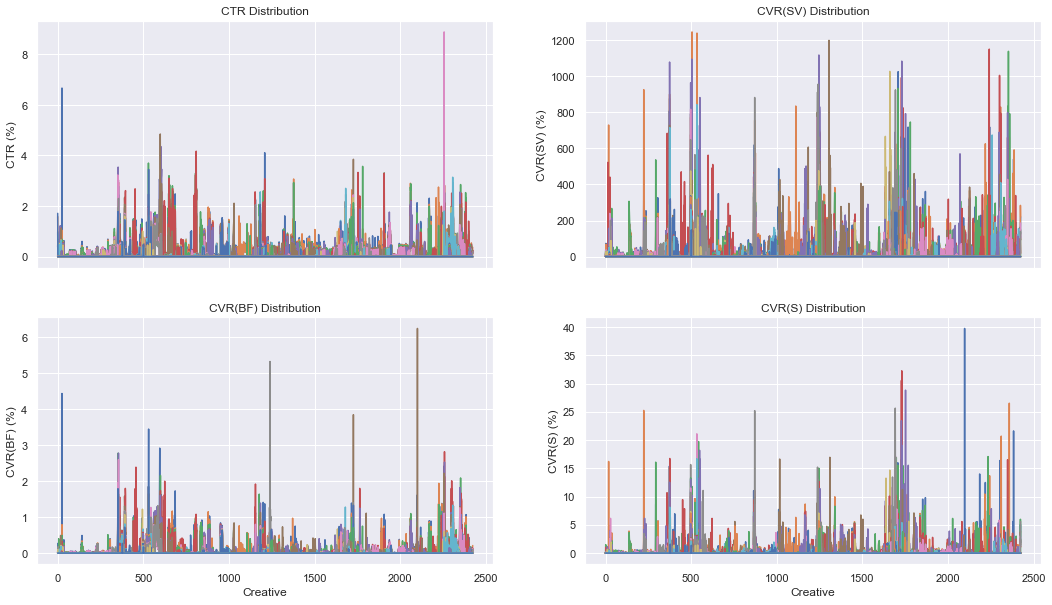

In [65]:
# Quick look at distributions
fig, ax = plt.subplots(2, 2, figsize=(18, 10), sharex=True)

week_data.reset_index()[ctr_w].plot(ax=ax[0,0], legend=None)
ax[0,0].title.set_text('CTR Distribution')
ax[0,0].set_xlabel('Creative')
ax[0,0].set_ylabel('CTR (%)')

week_data.reset_index()[cvrsv_w].plot(ax=ax[1,0], legend=None)
ax[0,1].title.set_text('CVR(SV) Distribution')
ax[0,1].set_xlabel('Creative')
ax[0,1].set_ylabel('CVR(SV) (%)')


week_data.reset_index()[cvrbf_w].plot(ax=ax[0,1], legend=None)
ax[1,0].title.set_text('CVR(BF) Distribution')
ax[1,0].set_xlabel('Creative')
ax[1,0].set_ylabel('CVR(BF) (%)')

week_data.reset_index()[cvrint_w].plot(ax=ax[1,1], legend=None)
ax[1,1].title.set_text('CVR(S) Distribution')
ax[1,1].set_xlabel('Creative')
ax[1,1].set_ylabel('CVR(S) (%)')

plt.show()

### Data Variables

In [66]:
social_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2452 entries, 0 to 13216
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Creative ID        2452 non-null   object 
 1   funnel             2452 non-null   object 
 2   publisher          2452 non-null   object 
 3   lob                2452 non-null   object 
 4   product            2452 non-null   object 
 5   theme              2452 non-null   object 
 6   kpi_audience       2452 non-null   object 
 7   creative_versions  2452 non-null   object 
 8   price              2452 non-null   object 
 9   price_placement    1242 non-null   object 
 10  discount           2452 non-null   float64
 11  offer_placement    1242 non-null   object 
 12  offer_group        2452 non-null   object 
 13  asset_type         2452 non-null   object 
 14  video_type         2360 non-null   object 
 15  length             2452 non-null   object 
dtypes: float64(1), object(1

In [67]:
social_data.duplicated().any()

False

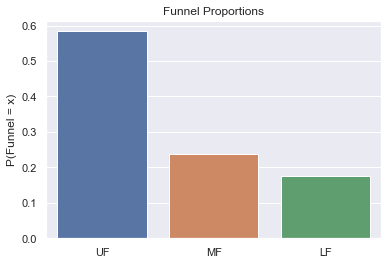

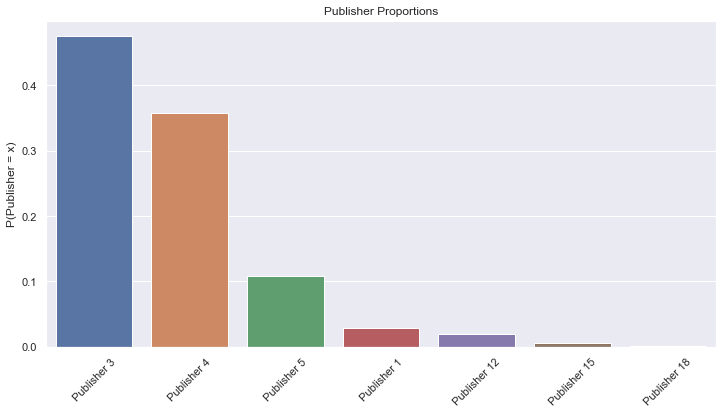

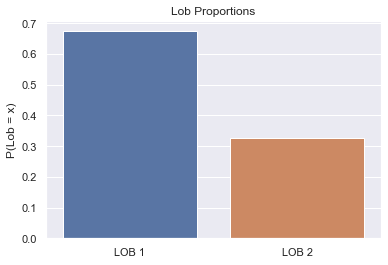

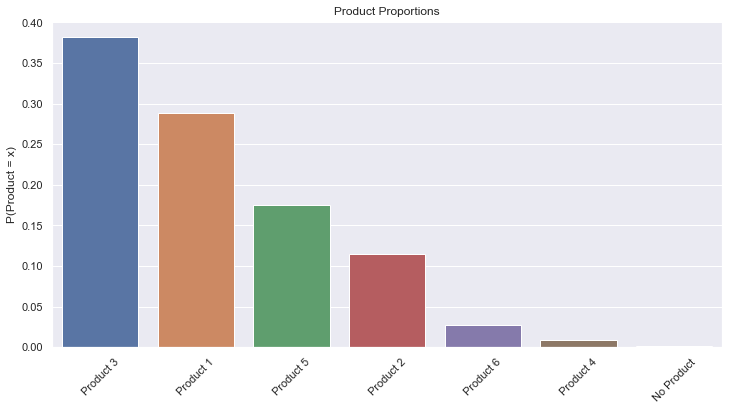

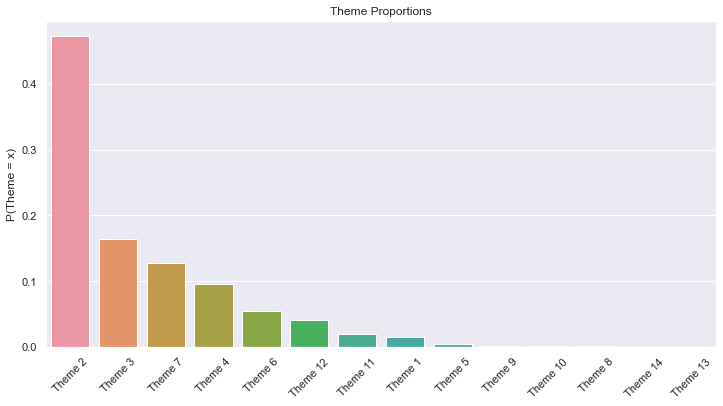

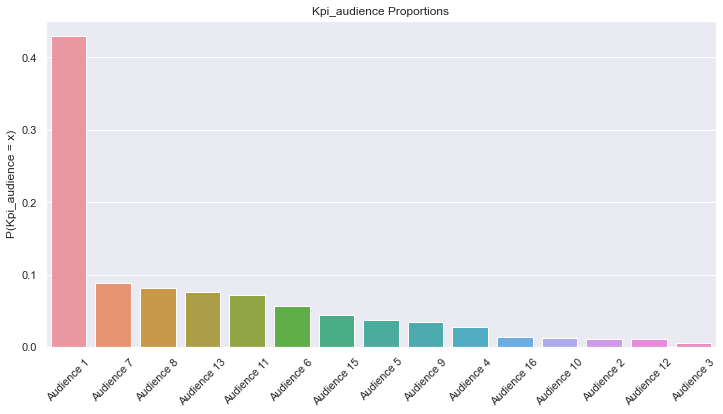

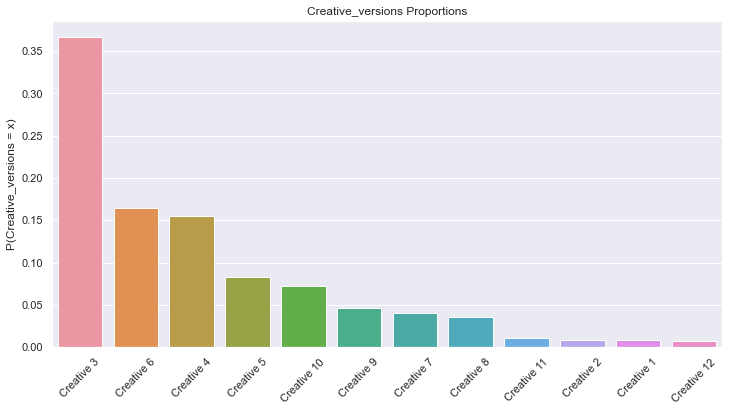

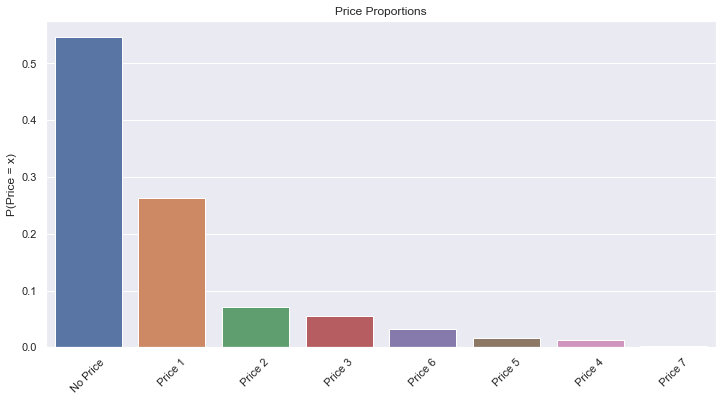

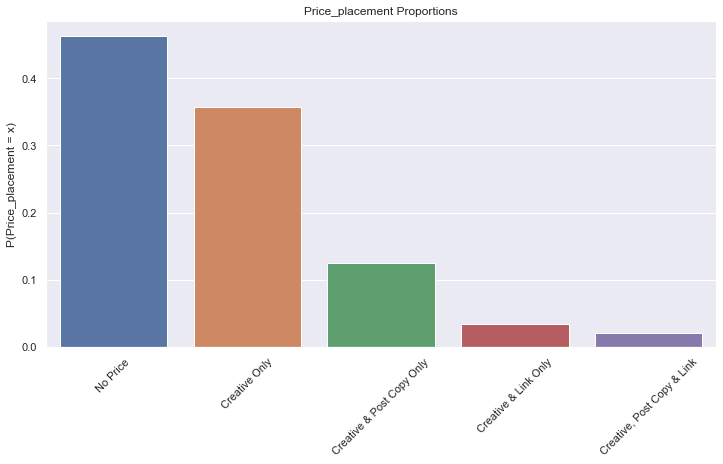

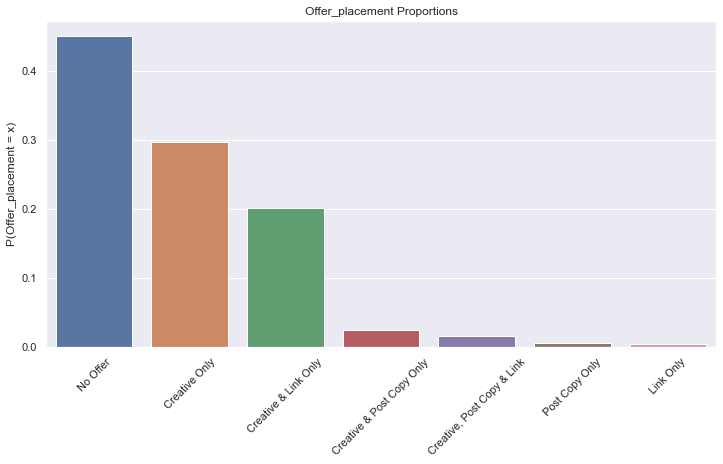

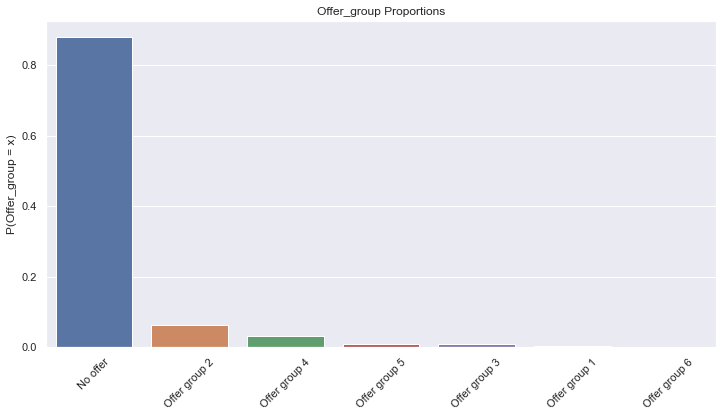

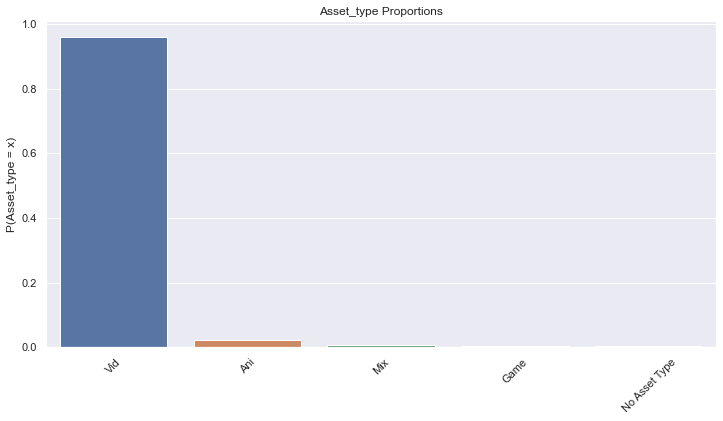

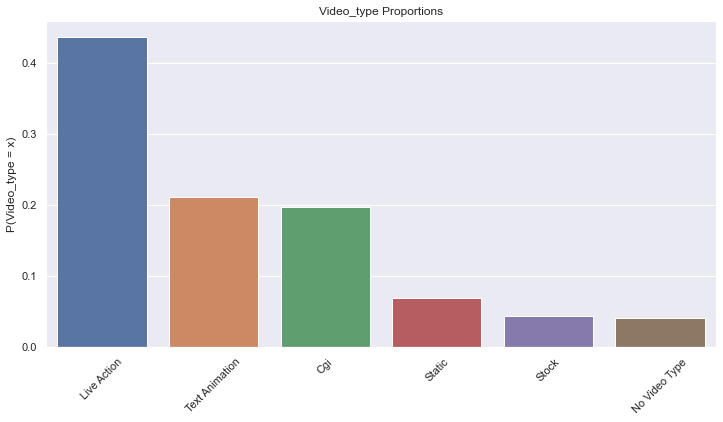

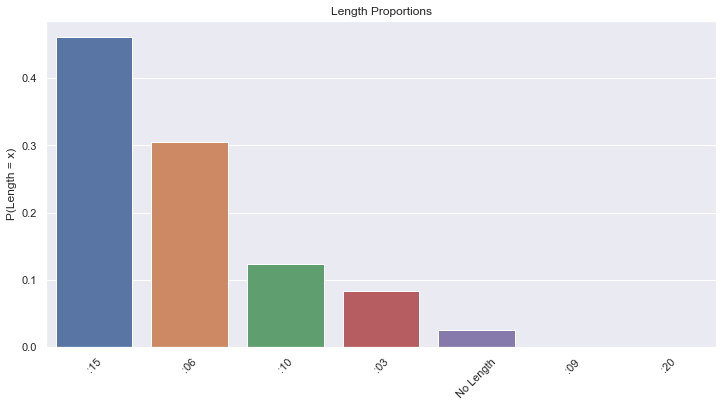

In [68]:
# Visualize proportions
cat_data = social_data.drop(columns='discount').fillna(np.nan)
for col in cat_data.columns[1:]:
    # Get proportions
    means = social_data[col].value_counts(normalize=True)

    # Formatting condition
    if len(means) > 4:
        plt.figure(figsize=(12, 6))
        plt.xticks(rotation=45)

    # Plot
    sns.barplot(x=means.index, y=col, data=means.to_frame())
    plt.title(f'{col.capitalize()} Proportions')
    plt.ylabel(f'P({col.capitalize()} = x)')
    plt.yticks()
    plt.show()

`Offer_group` and `Asset_type` both contain a value that occurs over 80% of the time in the data. These features will likely not prove useful in predicting due to low variation.

In [69]:
# Check for anomalies
social_data[social_data.discount < 0].shape

(0, 16)

In [70]:
# Check for anomalies
social_data[(social_data.price_placement == 'No Price') & (social_data.discount > 0)]

,Creative ID,funnel,publisher,lob,product,theme,kpi_audience,creative_versions,price,price_placement,discount,offer_placement,offer_group,asset_type,video_type,length
2150,Creative 2151,UF,Publisher 5,LOB 1,Product 1,Theme 2,Audience 11,Creative 5,No Price,No Price,10.0,Link Only,No offer,Vid,Live Action,:15


There seems to be only one creative where there is no price, yet there is a discount. Since it's only one creative, we can simply change the discount value to 0.

In [71]:
social_data.loc[2150, 'discount'] = 0

## Primary Learning Objectives

### PLO - Optimal mix of creatives per Funnel + Publisher

In [72]:
# Merge away outliers and merge raw week variables
social_data_plo1 = pd.merge(social_data, week_data[[]], left_index=True, right_index=True) \
    .merge(data.iloc[:, 18:], left_index=True, right_index=True)
social_data_plo1.head()

,Creative ID,funnel,publisher,lob,product,theme,kpi_audience,creative_versions,price,price_placement,discount,offer_placement,offer_group,asset_type,video_type,length,2019-12-30-Spend,2020-1-6-Spend,2020-1-13-Spend,2020-1-20-Spend,2020-1-27-Spend,2020-2-3-Spend,2020-2-10-Spend,2020-2-17-Spend,2020-2-24-Spend,2020-3-2-Spend,2020-3-9-Spend,2020-3-16-Spend,2020-4-13-Spend,2020-4-20-Spend,2020-4-27-Spend,2020-5-4-Spend,2020-5-11-Spend,2020-5-18-Spend,2020-5-25-Spend,2020-6-1-Spend,2020-6-8-Spend,2020-6-15-Spend,2020-6-22-Spend,2020-6-29-Spend,2020-7-6-Spend,2020-7-13-Spend,2020-7-20-Spend,2020-7-27-Spend,2020-8-3-Spend,2020-8-10-Spend,2020-8-17-Spend,2020-8-24-Spend,2020-8-31-Spend,2020-9-7-Spend,2020-9-14-Spend,2020-9-21-Spend,2020-9-28-Spend,2020-10-5-Spend,2020-10-12-Spend,2020-10-19-Spend,2020-10-26-Spend,2020-11-2-Spend,2020-11-9-Spend,2020-11-16-Spend,2020-11-23-Spend,2020-11-30-Spend,2020-12-7-Spend,2020-12-14-Spend,2020-12-21-Spend,2020-12-28-Spend,2021-1-4-Spend,2021-1-11-Spend,2021-1-18-Spend,2021-1-25-Spend,2021-2-1-Spend,2021-2-8-Spend,2021-2-15-Spend,2021-2-22-Spend,2021-3-1-Spend,2021-3-8-Spend,2021-3-15-Spend,2021-3-22-Spend,2021-3-29-Spend,2021-4-5-Spend,2021-4-12-Spend,2021-4-19-Spend,2021-4-26-Spend,2021-5-3-Spend,2021-5-10-Spend,2021-5-17-Spend,2021-5-24-Spend,2021-5-31-Spend,2021-6-7-Spend,2021-6-14-Spend,2021-6-21-Spend,2021-6-28-Spend,2021-7-5-Spend,2021-7-12-Spend,2021-7-19-Spend,2021-7-26-Spend,2021-8-2-Spend,2021-8-9-Spend,2021-8-16-Spend,2021-8-23-Spend,2021-8-30-Spend,2021-9-6-Spend,2021-9-13-Spend,2021-9-20-Spend,2021-9-27-Spend,2021-10-4-Spend,2021-10-11-Spend,2021-10-18-Spend,2021-10-25-Spend,2021-11-1-Spend,2021-11-8-Spend,2021-11-15-Spend,2021-11-22-Spend,2021-11-29-Spend,2021-12-6-Spend,2021-12-13-Spend,2021-12-20-Spend,2021-12-27-Spend,2019-12-30-Impressions,2020-1-6-Impressions,2020-1-13-Impressions,2020-1-20-Impressions,2020-1-27-Impressions,2020-2-3-Impressions,2020-2-10-Impressions,2020-2-17-Impressions,2020-2-24-Impressions,2020-3-2-Impressions,2020-3-9-Impressions,2020-3-16-Impressions,2020-4-13-Impressions,2020-4-20-Impressions,2020-4-27-Impressions,2020-5-4-Impressions,2020-5-11-Impressions,2020-5-18-Impressions,2020-5-25-Impressions,2020-6-1-Impressions,2020-6-8-Impressions,2020-6-15-Impressions,2020-6-22-Impressions,2020-6-29-Impressions,2020-7-6-Impressions,2020-7-13-Impressions,2020-7-20-Impressions,2020-7-27-Impressions,2020-8-3-Impressions,2020-8-10-Impressions,2020-8-17-Impressions,2020-8-24-Impressions,2020-8-31-Impressions,2020-9-7-Impressions,2020-9-14-Impressions,2020-9-21-Impressions,2020-9-28-Impressions,2020-10-5-Impressions,2020-10-12-Impressions,2020-10-19-Impressions,2020-10-26-Impressions,2020-11-2-Impressions,2020-11-9-Impressions,2020-11-16-Impressions,2020-11-23-Impressions,2020-11-30-Impressions,2020-12-7-Impressions,2020-12-14-Impressions,2020-12-21-Impressions,2020-12-28-Impressions,2021-1-4-Impressions,2021-1-11-Impressions,2021-1-18-Impressions,2021-1-25-Impressions,2021-2-1-Impressions,2021-2-8-Impressions,2021-2-15-Impressions,2021-2-22-Impressions,2021-3-1-Impressions,2021-3-8-Impressions,2021-3-15-Impressions,2021-3-22-Impressions,2021-3-29-Impressions,2021-4-5-Impressions,2021-4-12-Impressions,2021-4-19-Impressions,2021-4-26-Impressions,2021-5-3-Impressions,2021-5-10-Impressions,2021-5-17-Impressions,2021-5-24-Impressions,2021-5-31-Impressions,2021-6-7-Impressions,2021-6-14-Impressions,2021-6-21-Impressions,2021-6-28-Impressions,2021-7-5-Impressions,2021-7-12-Impressions,2021-7-19-Impressions,2021-7-26-Impressions,2021-8-2-Impressions,2021-8-9-Impressions,2021-8-16-Impressions,2021-8-23-Impressions,2021-8-30-Impressions,2021-9-6-Impressions,2021-9-13-Impressions,2021-9-20-Impressions,2021-9-27-Impressions,2021-10-4-Impressions,2021-10-11-Impressions,2021-10-18-Impressions,2021-10-25-Impressions,2021-11-1-Impressions,2021-11-8-Impressions,2021-11-15-Impressions,2021-11-22-Impressions,2021-11-29-Impressions,2021-12-6-Impressions,2021-12-13-Impressions,2021-12-2

In [73]:
# Data cleaning functions


def p2f(x):
    if type(x) == str:
        return float(x.strip('%'))
    return x


def dollar2f(x):
    if type(x) == str:
        x = x.replace(',', '')
        return float(x.strip('$'))
    return x


# Get column names
raw_weeks = [col for col in social_data_plo1.columns[16:]]
raw_spend_imp = raw_weeks[:204]
raw_kpi_weeks = raw_weeks[204:]

raw_ctr = [col for col in raw_kpi_weeks if col.endswith('CTR')]
raw_cvrbf = [col for col in raw_kpi_weeks if col.endswith('CVR (BF)')]
raw_cvrsv = [col for col in raw_kpi_weeks if col.endswith('CVR (SV)')]
raw_cvrs = [col for col in raw_kpi_weeks if col.endswith('CVR (S)')]
dates = [s[:-4] for s in raw_ctr]

# Clean data
social_data_plo1[raw_spend_imp] = social_data_plo1[raw_spend_imp].applymap(dollar2f)
social_data_plo1[raw_kpi_weeks] = social_data_plo1[raw_kpi_weeks].applymap(p2f)

In [74]:
to_keep = social_data_plo1.columns[:16]

# Separate funnels
plo1_upper_funnel = social_data_plo1[social_data_plo1.funnel == 'UF'].loc[:, to_keep].drop('funnel', axis=1)
plo1_middle_funnel = social_data_plo1[social_data_plo1.funnel == 'MF'].loc[:, to_keep].drop('funnel', axis=1)
plo1_lower_funnel = social_data_plo1[social_data_plo1.funnel == 'LF'].loc[:, to_keep].drop('funnel', axis=1)

# Avg CTR per creative
plo1_upper_funnel['Avg_CTR'] = social_data_plo1[raw_ctr].mean(axis=1)
plo1_middle_funnel['Avg_CVRSV'] = social_data_plo1[raw_cvrsv].mean(axis=1)
plo1_middle_funnel['Avg_CVRBF'] = social_data_plo1[raw_cvrbf].mean(axis=1)
plo1_lower_funnel['Avg_CVRS'] = social_data_plo1[raw_cvrs].mean(axis=1)

plo1_upper_funnel

,Creative ID,publisher,lob,product,theme,kpi_audience,creative_versions,price,price_placement,discount,offer_placement,offer_group,asset_type,video_type,length,Avg_CTR
264,Creative 265,Publisher 3,LOB 1,Product 5,Theme 2,Audience 6,Creative 4,No Price,NaN,0.0,NaN,No offer,Vid,Static,:15,0.056667
265,Creative 266,Publisher 3,LOB 1,Product 5,Theme 2,Audience 1,Creative 4,No Price,NaN,0.0,NaN,No offer,Vid,Static,:15,0.050000
266,Creative 267,Publisher 3,LOB 1,Product 5,Theme 2,Audience 10,Creative 4,No Price,NaN,0.0,NaN,No offer,Vid,Static,:15,0.043333
267,Creative 268,Publisher 3,LOB 1,Product 5,Theme 2,Audience 7,Creative 4,No Price,NaN,0.0,NaN,No offer,Vid,Static,:15,0.063333
268,Creative 269,Publisher 3,LOB 1,Product 5,Theme 2,Audience 12,Creative 4,No Price,NaN,0.0,NaN,No offer,Vid,Static,:15,0.070000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13114,Creative 13115,Publisher 4,LOB 1,Product 3,Theme 3,Audience 11,Creative 6,No Price,No Price,0.0,No Offer,No offer,Vid,Text Animation,:06,0.266667
13115,Creative 13116,Publisher 4,LOB 2,Product 3,Theme 3,Audience 6,Creative 6,No Price,No Price,0.0,No Offer,No offer,Vid,Text Animation,:06,0.320000
13116,Creative 13117,Publisher 4,LOB 2,Product 3,Theme 3,Audience 1,Creative 6,No Price,No Price,0.0,No Offer,No offer,Vid,Text Animation,:06,0.293333
13117,Creative 13118,Publisher 4,LOB 2,Product 3,Theme 3,Audience 5,Creative 6,No Price,No Price,0.0,No Offer,No offer,Vid,Text Animation,:06,0.303333


In [75]:
# Check which columns contain missing values
plo1_upper_funnel.isnull().sum()

Creative ID            0
publisher              0
lob                    0
product                0
theme                  0
kpi_audience           0
creative_versions      0
price                  0
price_placement      827
discount               0
offer_placement      827
offer_group            0
asset_type             0
video_type            56
length                 0
Avg_CTR                0
dtype: int64

In [76]:
plo1_middle_funnel.isnull().sum()

Creative ID            0
publisher              0
lob                    0
product                0
theme                  0
kpi_audience           0
creative_versions      0
price                  0
price_placement      137
discount               0
offer_placement      137
offer_group            0
asset_type             0
video_type            16
length                 0
Avg_CVRSV              0
Avg_CVRBF              0
dtype: int64

In [77]:
plo1_lower_funnel.isnull().sum()

Creative ID            0
publisher              0
lob                    0
product                0
theme                  0
kpi_audience           0
creative_versions      0
price                  0
price_placement      235
discount               0
offer_placement      235
offer_group            0
asset_type             0
video_type            20
length                 0
Avg_CVRS               0
dtype: int64

None of the numeric columns are missing any data so we can just fill in the NaNs with "missing".

In [78]:
plo1_upper_funnel.fillna('Missing', inplace=True)
plo1_middle_funnel.fillna('Missing', inplace=True)
plo1_lower_funnel.fillna('Missing', inplace=True)

#### Which creative elements have the highest average funnel specific CTR?

In [79]:
plo1_upper_funnel['Avg_CTR'].describe()

count    1432.000000
mean        0.190369
std         0.161945
min         0.000000
25%         0.067500
50%         0.138333
75%         0.277938
max         1.380000
Name: Avg_CTR, dtype: float64

In [80]:
# Attributes to group on
key_attributes = ['publisher', 'lob', 'product', 'kpi_audience']

combinations_UF = plo1_upper_funnel.groupby(key_attributes).agg(
    creative_members = ('Avg_CTR', 'count'),
    avg_ctr = ('Avg_CTR', 'mean')
)
# Top CTR elements
ctr_top10 = combinations_UF.reset_index().sort_values(['avg_ctr', 'creative_members'], ascending=[0, 0]).head(10)
ctr_top10

,publisher,lob,product,kpi_audience,creative_members,avg_ctr
18,Publisher 1,LOB 2,Product 6,Audience 1,1,0.750000
24,Publisher 12,LOB 1,Product 5,Audience 1,9,0.733778
22,Publisher 12,LOB 1,Product 2,Audience 13,3,0.709848
137,Publisher 4,LOB 1,Product 5,Audience 3,1,0.676667
124,Publisher 4,LOB 1,Product 3,Audience 3,2,0.643000
112,Publisher 4,LOB 1,Product 1,Audience 9,1,0.638000
19,Publisher 12,LOB 1,Product 1,Audience 1,13,0.597205
21,Publisher 12,LOB 1,Product 2,Audience 1,2,0.510000
20,Publisher 12,LOB 1,Product 1,Audience 13,9,0.505009
25,Publisher 12,LOB 1,Product 5,Audience 7,3,0.492333


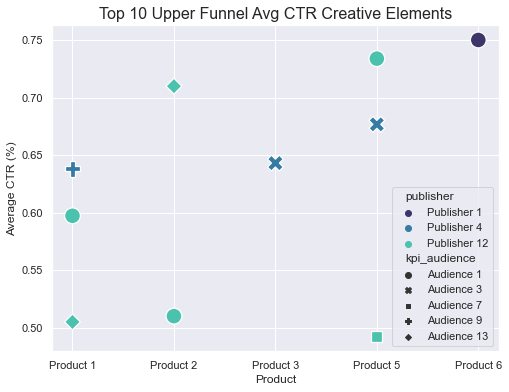

In [81]:
# Plot top 10
pub_order = ['Publisher 1', 'Publisher 4', 'Publisher 12']
audience_order = ['Audience 1', 'Audience 3', 'Audience 7', 'Audience 9', 'Audience 13']

plt.figure(figsize=(8, 6))
sns.scatterplot(x='product', y='avg_ctr', hue='publisher', hue_order=pub_order,
                style='kpi_audience', style_order=audience_order, s=250, palette='mako',
                data=ctr_top10.sort_values('product')
)
plt.title('Top 10 Upper Funnel Avg CTR Creative Elements', fontsize=16)
plt.xlabel('Product')
plt.ylabel('Average CTR (%)')
plt.show()

In [82]:
# Bottom CTR elements
combinations_UF.reset_index().sort_values(['avg_ctr', 'creative_members'], ascending=[0, 0]).tail(10)

,publisher,lob,product,kpi_audience,creative_members,avg_ctr
178,Publisher 5,LOB 1,Product 2,Audience 11,2,0.034000
185,Publisher 5,LOB 1,Product 5,Audience 10,7,0.033061
190,Publisher 5,LOB 1,Product 5,Audience 7,4,0.029500
188,Publisher 5,LOB 1,Product 5,Audience 13,11,0.027273
189,Publisher 5,LOB 1,Product 5,Audience 6,8,0.022417
184,Publisher 5,LOB 1,Product 5,Audience 1,30,0.020006
191,Publisher 5,LOB 1,Product 5,Audience 8,6,0.017444
186,Publisher 5,LOB 1,Product 5,Audience 11,8,0.014583
192,Publisher 5,LOB 2,Product 6,Audience 1,6,0.000000
182,Publisher 5,LOB 1,Product 3,Audience 1,3,0.000000


#### Which creative elements have the highest average funnel specific CVR(SV)?

In [83]:
plo1_middle_funnel['Avg_CVRSV'].describe()

count    578.000000
mean       0.428859
std        0.307376
min        0.000000
25%        0.167795
50%        0.386250
75%        0.646250
max        1.555000
Name: Avg_CVRSV, dtype: float64

In [84]:
# Attributes to group on
key_attributes = ['publisher', 'lob', 'product', 'theme', 'kpi_audience']

combinations_SV_MF = plo1_middle_funnel.groupby(key_attributes).agg(
    creative_members = ('Avg_CVRSV', 'count'),
    avg_cvrsv = ('Avg_CVRSV', 'mean')
)
# Top SV CVR elements
cvrsv_top10 = combinations_SV_MF.reset_index().sort_values(['avg_cvrsv', 'creative_members'], ascending=[0, 0]).head(10)
cvrsv_top10

,publisher,lob,product,theme,kpi_audience,creative_members,avg_cvrsv
55,Publisher 3,LOB 2,Product 1,Theme 2,Audience 8,1,1.320000
4,Publisher 3,LOB 1,Product 1,Theme 2,Audience 11,1,1.138182
41,Publisher 3,LOB 1,Product 3,Theme 3,Audience 8,4,1.128750
53,Publisher 3,LOB 2,Product 1,Theme 2,Audience 6,1,1.077273
3,Publisher 3,LOB 1,Product 1,Theme 2,Audience 1,1,1.034545
51,Publisher 3,LOB 2,Product 1,Theme 2,Audience 11,1,1.033636
64,Publisher 3,LOB 2,Product 2,Theme 2,Audience 9,1,1.010000
9,Publisher 3,LOB 1,Product 1,Theme 2,Audience 8,1,1.005000
18,Publisher 3,LOB 1,Product 2,Theme 2,Audience 4,1,0.927500
22,Publisher 3,LOB 1,Product 2,Theme 2,Audience 9,1,0.922500


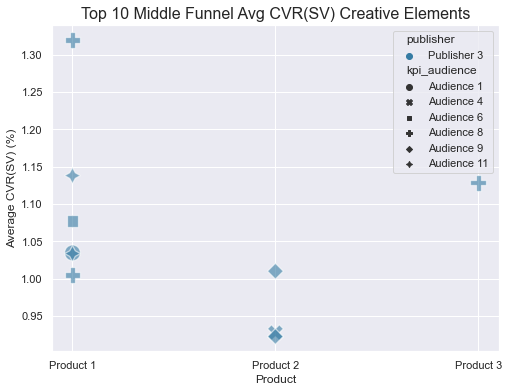

In [85]:
# Plot top 10
audience_order = ['Audience 1', 'Audience 4', 'Audience 6', 'Audience 8', 'Audience 9', 'Audience 11']

plt.figure(figsize=(8, 6))
g = sns.scatterplot(x='product', y='avg_cvrsv', hue='publisher',
                style='kpi_audience', style_order=audience_order, s=250, palette='mako', alpha=.6,
                data=cvrsv_top10.sort_values('product')
)
plt.title('Top 10 Middle Funnel Avg CVR(SV) Creative Elements', fontsize=16)
plt.xlabel('Product')
plt.ylabel('Average CVR(SV) (%)')

plt.show()

In [86]:
# Bottom SV CVR elements
combinations_SV_MF.reset_index().sort_values(['avg_cvrsv', 'creative_members'], ascending=[0, 0]).tail(10)

,publisher,lob,product,theme,kpi_audience,creative_members,avg_cvrsv
166,Publisher 5,LOB 1,Product 3,Theme 6,Audience 1,9,0.054630
158,Publisher 5,LOB 1,Product 1,Theme 1,Audience 2,5,0.051689
163,Publisher 5,LOB 1,Product 3,Theme 2,Audience 5,9,0.047778
164,Publisher 5,LOB 1,Product 3,Theme 4,Audience 1,6,0.040889
161,Publisher 5,LOB 1,Product 2,Theme 1,Audience 2,1,0.039333
160,Publisher 5,LOB 1,Product 1,Theme 4,Audience 1,1,0.030000
12,Publisher 3,LOB 1,Product 1,Theme 9,Audience 9,1,0.030000
165,Publisher 5,LOB 1,Product 3,Theme 4,Audience 5,3,0.028222
0,Publisher 1,LOB 1,Product 1,Theme 1,Audience 1,2,0.000000
23,Publisher 3,LOB 1,Product 3,Theme 10,Audience 1,1,0.000000


#### Which creative elements have the highest average funnel specific CVR(BF)?

In [87]:
plo1_middle_funnel['Avg_CVRBF'].describe()

count    578.000000
mean      50.719216
std       53.865749
min        0.000000
25%       11.452214
50%       34.028333
75%       75.029500
max      368.245000
Name: Avg_CVRBF, dtype: float64

In [88]:
# Top BF CVR elements
combinations_BF_MF = plo1_middle_funnel.groupby(key_attributes).agg(
    creative_members = ('Avg_CVRBF', 'count'),
    avg_cvrbf = ('Avg_CVRBF', 'mean')
)
cvrbf_top10 = combinations_BF_MF.reset_index().sort_values(['avg_cvrbf', 'creative_members'], ascending=[0, 0]).head(10)
cvrbf_top10

,publisher,lob,product,theme,kpi_audience,creative_members,avg_cvrbf
41,Publisher 3,LOB 1,Product 3,Theme 3,Audience 8,4,226.033125
79,Publisher 3,LOB 2,Product 3,Theme 3,Audience 7,1,195.030000
103,Publisher 4,LOB 1,Product 2,Theme 2,Audience 8,1,185.660000
97,Publisher 4,LOB 1,Product 2,Theme 2,Audience 11,1,179.950000
100,Publisher 4,LOB 1,Product 2,Theme 2,Audience 4,1,174.585000
76,Publisher 3,LOB 2,Product 3,Theme 3,Audience 15,2,168.245333
98,Publisher 4,LOB 1,Product 2,Theme 2,Audience 13,1,160.660000
36,Publisher 3,LOB 1,Product 3,Theme 3,Audience 13,5,154.471929
104,Publisher 4,LOB 1,Product 2,Theme 2,Audience 9,1,152.102500
88,Publisher 4,LOB 1,Product 1,Theme 2,Audience 11,2,149.271364


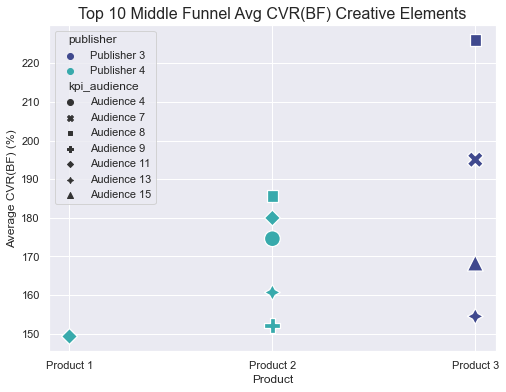

In [89]:
# Plot top 10
pub_order = ['Publisher 3', 'Publisher 4']
audience_order = ['Audience 4', 'Audience 7', 'Audience 8', 'Audience 9', 'Audience 11', 'Audience 13', 'Audience 15']

plt.figure(figsize=(8, 6))
sns.scatterplot(x='product', y='avg_cvrbf', hue='publisher', hue_order=pub_order,
                style='kpi_audience', style_order=audience_order, s=250, palette='mako',
                data=cvrbf_top10.sort_values('product')
)
plt.title('Top 10 Middle Funnel Avg CVR(BF) Creative Elements', fontsize=16)
plt.xlabel('Product')
plt.ylabel('Average CVR(BF) (%)')

plt.show()

In [90]:
# Bottom BF CVR elements
combinations_BF_MF.reset_index().sort_values(['avg_cvrbf', 'creative_members'], ascending=[0, 0]).tail(10)

,publisher,lob,product,theme,kpi_audience,creative_members,avg_cvrbf
19,Publisher 3,LOB 1,Product 2,Theme 2,Audience 6,1,7.925000
10,Publisher 3,LOB 1,Product 1,Theme 4,Audience 1,1,7.696667
56,Publisher 3,LOB 2,Product 1,Theme 4,Audience 1,1,7.533333
82,Publisher 3,LOB 2,Product 3,Theme 4,Audience 1,5,7.300200
54,Publisher 3,LOB 2,Product 1,Theme 2,Audience 7,3,3.495606
39,Publisher 3,LOB 1,Product 3,Theme 3,Audience 6,4,0.000000
59,Publisher 3,LOB 2,Product 2,Theme 2,Audience 15,3,0.000000
0,Publisher 1,LOB 1,Product 1,Theme 1,Audience 1,2,0.000000
9,Publisher 3,LOB 1,Product 1,Theme 2,Audience 8,1,0.000000
55,Publisher 3,LOB 2,Product 1,Theme 2,Audience 8,1,0.000000


#### Which creative elements have the highest average funnel specific CVR(S)?

In [91]:
plo1_lower_funnel['Avg_CVRS'].describe()

count    415.000000
mean       2.253517
std        1.925809
min        0.000000
25%        1.045667
50%        1.781667
75%        3.092434
max       14.924000
Name: Avg_CVRS, dtype: float64

In [92]:
# Attributes to group on
key_attributes = ['publisher', 'lob', 'product', 'theme', 'kpi_audience']

combinations_LF = plo1_lower_funnel.groupby(key_attributes).agg(
    creative_members = ('Avg_CVRS', 'count'),
    avg_cvrs = ('Avg_CVRS', 'mean')
)
# Top Sales CVR  elements
cvrs_top10 = combinations_LF.reset_index().sort_values(['avg_cvrs', 'creative_members'], ascending=[0, 0]).head(10)
cvrs_top10

,publisher,lob,product,theme,kpi_audience,creative_members,avg_cvrs
9,Publisher 3,LOB 1,Product 2,Theme 3,Audience 11,1,9.113333
45,Publisher 4,LOB 1,Product 2,Theme 3,Audience 11,1,4.860000
6,Publisher 3,LOB 1,Product 2,Theme 2,Audience 1,9,4.053087
3,Publisher 3,LOB 1,Product 1,Theme 2,Audience 1,24,3.986004
21,Publisher 3,LOB 1,Product 5,Theme 12,Audience 13,3,3.889167
14,Publisher 3,LOB 1,Product 3,Theme 3,Audience 1,30,3.840188
17,Publisher 3,LOB 1,Product 3,Theme 7,Audience 1,5,3.545600
16,Publisher 3,LOB 1,Product 3,Theme 6,Audience 1,8,3.491042
20,Publisher 3,LOB 1,Product 5,Theme 12,Audience 1,6,3.401278
44,Publisher 4,LOB 1,Product 2,Theme 3,Audience 1,5,3.388226


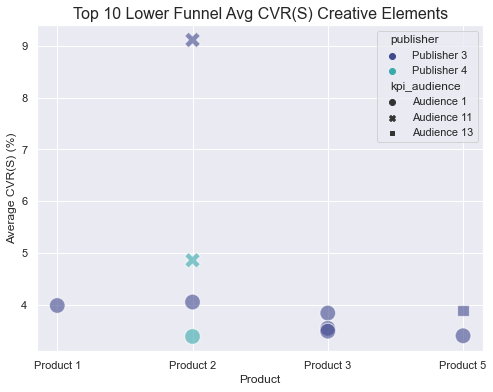

In [93]:
# Plot top 10
pub_order = ['Publisher 3', 'Publisher 4']
audience_order = ['Audience 1', 'Audience 11', 'Audience 13']

plt.figure(figsize=(8, 6))
sns.scatterplot(x='product', y='avg_cvrs', hue='publisher', hue_order=pub_order,
                style='kpi_audience', style_order=audience_order, s=250, palette='mako', alpha=.6,
                data=cvrs_top10.sort_values('product')
)
plt.title('Top 10 Lower Funnel Avg CVR(S) Creative Elements', fontsize=16)
plt.xlabel('Product')
plt.ylabel('Average CVR(S) (%)')

#plt.legend(loc='upper center')
plt.show()

In [94]:
# Bottom Sales CVR elements
combinations_LF.reset_index().sort_values(['avg_cvrs', 'creative_members'], ascending=[0, 0]).tail(10)

,publisher,lob,product,theme,kpi_audience,creative_members,avg_cvrs
76,Publisher 5,LOB 1,Product 3,Theme 1,Audience 2,2,0.0
0,Publisher 1,LOB 1,Product 3,Theme 1,Audience 1,1,0.0
2,Publisher 12,LOB 1,Product 5,Theme 7,Audience 1,1,0.0
7,Publisher 3,LOB 1,Product 2,Theme 2,Audience 11,1,0.0
18,Publisher 3,LOB 1,Product 4,Theme 14,Audience 1,1,0.0
19,Publisher 3,LOB 1,Product 4,Theme 3,Audience 1,1,0.0
55,Publisher 4,LOB 1,Product 4,Theme 3,Audience 9,1,0.0
67,Publisher 4,LOB 2,Product 3,Theme 6,Audience 1,1,0.0
73,Publisher 5,LOB 1,Product 2,Theme 1,Audience 1,1,0.0
75,Publisher 5,LOB 1,Product 3,Theme 1,Audience 1,1,0.0


#### Secondary Learning Outcomes - Additional data points to capture

In [95]:
# Top 10 average CTR on all elements
all_attributes = list(plo1_upper_funnel.columns[1:-1])

combinations_UF = plo1_upper_funnel.groupby(all_attributes).agg(
    creative_members = ('Avg_CTR', 'count'),
    avg_ctr = ('Avg_CTR', 'mean')
)
combinations_UF.reset_index().sort_values(['avg_ctr', 'creative_members'], ascending=[0, 0]).head(10)

,publisher,lob,product,theme,kpi_audience,creative_versions,price,price_placement,discount,offer_placement,offer_group,asset_type,video_type,length,creative_members,avg_ctr
72,Publisher 12,LOB 1,Product 1,Theme 6,Audience 1,Creative 10,No Price,No Price,0.0,No Offer,No offer,Vid,Live Action,:15,1,0.977000
85,Publisher 12,LOB 1,Product 5,Theme 7,Audience 1,Creative 11,Price 2,Missing,0.0,Missing,No offer,Vid,Cgi,:10,1,0.925000
56,Publisher 12,LOB 1,Product 1,Theme 2,Audience 1,Creative 10,No Price,No Price,0.0,No Offer,No offer,Vid,Live Action,:15,1,0.883000
89,Publisher 12,LOB 1,Product 5,Theme 7,Audience 1,Creative 5,No Price,Missing,0.0,Missing,Offer group 2,Vid,Cgi,:10,1,0.870000
71,Publisher 12,LOB 1,Product 1,Theme 6,Audience 1,Creative 10,No Price,No Price,0.0,No Offer,No offer,Vid,Live Action,:06,2,0.852500
83,Publisher 12,LOB 1,Product 5,Theme 3,Audience 1,Creative 5,Price 6,Missing,0.0,Missing,Offer group 4,Vid,Cgi,:10,1,0.765000
82,Publisher 12,LOB 1,Product 5,Theme 12,Audience 1,Creative 3,No Price,Missing,0.0,Missing,Offer group 2,Vid,Live Action,:06,2,0.750000
55,Publisher 1,LOB 2,Product 6,Theme 7,Audience 1,Creative 3,Price 6,Missing,0.0,Missing,Offer group 4,Vid,Cgi,:06,1,0.750000
76,Publisher 12,LOB 1,Product 2,Theme 2,Audience 13,Creative 3,No Price,Missing,0.0,Missing,No offer,Vid,Live Action,:15,1,0.747273
75,Publisher 12,LOB 1,Product 2,Theme 2,Audience 13,Creative 3,No Price,Missing,0.0,Missing,No offer,Vid,Live Action,:06,1,0.737273


In [96]:
# Top 10 average CVR(SV) on all elements
combinations_MF = plo1_middle_funnel.groupby(all_attributes).agg(
    creative_members = ('Avg_CVRSV', 'count'),
    avg_cvrsv = ('Avg_CVRSV', 'mean')
)
combinations_MF.reset_index().sort_values(['avg_cvrsv', 'creative_members'], ascending=[0, 0]).head(10)

,publisher,lob,product,theme,kpi_audience,creative_versions,price,price_placement,discount,offer_placement,offer_group,asset_type,video_type,length,creative_members,avg_cvrsv
180,Publisher 3,LOB 2,Product 3,Theme 2,Audience 9,Creative 3,Price 1,Creative & Post Copy Only,10.0,"Creative, Post Copy & Link",No offer,Vid,Live Action,:15,1,1.555000
121,Publisher 3,LOB 2,Product 1,Theme 2,Audience 8,Creative 3,No Price,Missing,0.0,Missing,No offer,Vid,Cgi,:06,1,1.320000
87,Publisher 3,LOB 1,Product 3,Theme 3,Audience 1,Creative 6,No Price,Missing,0.0,Missing,No offer,Vid,Text Animation,:06,1,1.156667
136,Publisher 3,LOB 2,Product 2,Theme 2,Audience 8,Creative 3,Price 1,Missing,10.0,Missing,No offer,Vid,Text Animation,:15,1,1.140000
7,Publisher 3,LOB 1,Product 1,Theme 2,Audience 11,Creative 5,No Price,Missing,0.0,Missing,No offer,Vid,Cgi,:06,1,1.138182
96,Publisher 3,LOB 1,Product 3,Theme 3,Audience 8,Creative 6,No Price,No Price,0.0,No Offer,No offer,Vid,Text Animation,:06,4,1.128750
97,Publisher 3,LOB 1,Product 3,Theme 3,Audience 9,Creative 6,No Price,Missing,0.0,Missing,No offer,Vid,Text Animation,:06,1,1.106667
13,Publisher 3,LOB 1,Product 1,Theme 2,Audience 6,Creative 8,No Price,Missing,0.0,Missing,No offer,Vid,Text Animation,:06,1,1.097273
118,Publisher 3,LOB 2,Product 1,Theme 2,Audience 6,Creative 8,No Price,Missing,0.0,Missing,No offer,Vid,Text Animation,:06,1,1.077273
25,Publisher 3,LOB 1,Product 2,Theme 2,Audience 11,Creative 5,Price 1,Missing,10.0,Missing,No offer,Vid,Text Animation,:15,1,1.042500


In [97]:
# Top 10 average CVR(BF) on all elements
combinations_BF_MF = plo1_middle_funnel.groupby(all_attributes).agg(
    creative_members = ('Avg_CVRBF', 'count'),
    avg_cvrbf = ('Avg_CVRBF', 'mean')
)
combinations_BF_MF.reset_index().sort_values(['avg_cvrbf', 'creative_members'], ascending=[0, 0]).head(10)

,publisher,lob,product,theme,kpi_audience,creative_versions,price,price_placement,discount,offer_placement,offer_group,asset_type,video_type,length,creative_members,avg_cvrbf
96,Publisher 3,LOB 1,Product 3,Theme 3,Audience 8,Creative 6,No Price,No Price,0.0,No Offer,No offer,Vid,Text Animation,:06,4,226.033125
272,Publisher 4,LOB 1,Product 3,Theme 4,Audience 1,Creative 4,Price 1,Creative Only,20.0,Creative Only,No offer,Vid,Live Action,:15,1,203.405000
188,Publisher 3,LOB 2,Product 3,Theme 3,Audience 7,Creative 6,No Price,No Price,0.0,No Offer,No offer,Vid,Text Animation,:06,1,195.030000
36,Publisher 3,LOB 1,Product 2,Theme 2,Audience 8,Creative 3,Price 1,Missing,10.0,Missing,No offer,Vid,Text Animation,:15,1,189.147500
228,Publisher 4,LOB 1,Product 2,Theme 2,Audience 8,Creative 3,No Price,Missing,0.0,Missing,No offer,Vid,Live Action,:06,1,185.660000
220,Publisher 4,LOB 1,Product 2,Theme 2,Audience 11,Creative 3,No Price,Missing,0.0,Missing,No offer,Vid,Live Action,:06,1,179.950000
158,Publisher 3,LOB 2,Product 3,Theme 2,Audience 4,Creative 3,Price 1,Creative & Post Copy Only,10.0,"Creative, Post Copy & Link",No offer,Vid,Live Action,:15,1,174.941667
225,Publisher 4,LOB 1,Product 2,Theme 2,Audience 4,Creative 3,No Price,Missing,0.0,Missing,No offer,Vid,Live Action,:06,1,174.585000
185,Publisher 3,LOB 2,Product 3,Theme 3,Audience 15,Creative 6,No Price,No Price,0.0,No Offer,No offer,Vid,Text Animation,:06,2,168.245333
207,Publisher 4,LOB 1,Product 1,Theme 2,Audience 11,Creative 5,No Price,Missing,0.0,Missing,No offer,Vid,Cgi,:06,1,161.742727


In [98]:
# Top 10 average CVR(S) on all elements
combinations_LF = plo1_lower_funnel.groupby(all_attributes).agg(
    creative_members = ('Avg_CVRS', 'count'),
    avg_cvrs = ('Avg_CVRS', 'mean')
)
combinations_LF.reset_index().sort_values(['avg_cvrs', 'creative_members'], ascending=[0, 0]).head(10)

,publisher,lob,product,theme,kpi_audience,creative_versions,price,price_placement,discount,offer_placement,offer_group,asset_type,video_type,length,creative_members,avg_cvrs
41,Publisher 3,LOB 1,Product 2,Theme 2,Audience 1,Creative 6,Price 5,Missing,10.0,Missing,No offer,Vid,Stock,:06,1,13.660000
9,Publisher 3,LOB 1,Product 1,Theme 2,Audience 1,Creative 4,Price 1,Creative & Link Only,15.0,Post Copy Only,No offer,Vid,Live Action,:03,1,10.696250
75,Publisher 3,LOB 1,Product 3,Theme 3,Audience 1,Creative 6,Price 2,"Creative, Post Copy & Link",15.0,Creative Only,No offer,Vid,Text Animation,:03,1,10.426667
48,Publisher 3,LOB 1,Product 2,Theme 3,Audience 11,Creative 6,Price 1,Missing,10.0,Missing,No offer,Vid,Text Animation,:03,1,9.113333
74,Publisher 3,LOB 1,Product 3,Theme 3,Audience 1,Creative 6,Price 2,Creative Only,20.0,Creative Only,No offer,Vid,Live Action,:15,3,8.607333
25,Publisher 3,LOB 1,Product 1,Theme 2,Audience 1,Creative 8,Price 1,Missing,0.0,Missing,No offer,Vid,Text Animation,:03,1,8.501000
134,Publisher 3,LOB 2,Product 2,Theme 2,Audience 1,Creative 8,Price 1,Missing,0.0,Missing,No offer,Vid,Text Animation,:03,1,7.848000
19,Publisher 3,LOB 1,Product 1,Theme 2,Audience 1,Creative 5,Price 1,Missing,0.0,Missing,No offer,Vid,Live Action,:03,1,7.206400
118,Publisher 3,LOB 2,Product 1,Theme 2,Audience 1,Creative 8,Price 1,Missing,0.0,Missing,No offer,Vid,Text Animation,:03,1,6.758182
36,Publisher 3,LOB 1,Product 2,Theme 2,Audience 1,Creative 4,Price 1,Missing,0.0,Missing,No offer,Vid,Text Animation,:03,1,6.748000


Here are the additional data points to capture. These are the creatives with the highest average KPI grouped by all attributes.

### PLO - Impact of number of creatives in market on performance

In [99]:
# Merge away outliers and merge raw week variables
social_data_plo2 = pd.merge(social_data, week_data[[]], left_index=True, right_index=True) \
    .merge(data.iloc[:, 18:], left_index=True, right_index=True)
social_data_plo2.head()

,Creative ID,funnel,publisher,lob,product,theme,kpi_audience,creative_versions,price,price_placement,discount,offer_placement,offer_group,asset_type,video_type,length,2019-12-30-Spend,2020-1-6-Spend,2020-1-13-Spend,2020-1-20-Spend,2020-1-27-Spend,2020-2-3-Spend,2020-2-10-Spend,2020-2-17-Spend,2020-2-24-Spend,2020-3-2-Spend,2020-3-9-Spend,2020-3-16-Spend,2020-4-13-Spend,2020-4-20-Spend,2020-4-27-Spend,2020-5-4-Spend,2020-5-11-Spend,2020-5-18-Spend,2020-5-25-Spend,2020-6-1-Spend,2020-6-8-Spend,2020-6-15-Spend,2020-6-22-Spend,2020-6-29-Spend,2020-7-6-Spend,2020-7-13-Spend,2020-7-20-Spend,2020-7-27-Spend,2020-8-3-Spend,2020-8-10-Spend,2020-8-17-Spend,2020-8-24-Spend,2020-8-31-Spend,2020-9-7-Spend,2020-9-14-Spend,2020-9-21-Spend,2020-9-28-Spend,2020-10-5-Spend,2020-10-12-Spend,2020-10-19-Spend,2020-10-26-Spend,2020-11-2-Spend,2020-11-9-Spend,2020-11-16-Spend,2020-11-23-Spend,2020-11-30-Spend,2020-12-7-Spend,2020-12-14-Spend,2020-12-21-Spend,2020-12-28-Spend,2021-1-4-Spend,2021-1-11-Spend,2021-1-18-Spend,2021-1-25-Spend,2021-2-1-Spend,2021-2-8-Spend,2021-2-15-Spend,2021-2-22-Spend,2021-3-1-Spend,2021-3-8-Spend,2021-3-15-Spend,2021-3-22-Spend,2021-3-29-Spend,2021-4-5-Spend,2021-4-12-Spend,2021-4-19-Spend,2021-4-26-Spend,2021-5-3-Spend,2021-5-10-Spend,2021-5-17-Spend,2021-5-24-Spend,2021-5-31-Spend,2021-6-7-Spend,2021-6-14-Spend,2021-6-21-Spend,2021-6-28-Spend,2021-7-5-Spend,2021-7-12-Spend,2021-7-19-Spend,2021-7-26-Spend,2021-8-2-Spend,2021-8-9-Spend,2021-8-16-Spend,2021-8-23-Spend,2021-8-30-Spend,2021-9-6-Spend,2021-9-13-Spend,2021-9-20-Spend,2021-9-27-Spend,2021-10-4-Spend,2021-10-11-Spend,2021-10-18-Spend,2021-10-25-Spend,2021-11-1-Spend,2021-11-8-Spend,2021-11-15-Spend,2021-11-22-Spend,2021-11-29-Spend,2021-12-6-Spend,2021-12-13-Spend,2021-12-20-Spend,2021-12-27-Spend,2019-12-30-Impressions,2020-1-6-Impressions,2020-1-13-Impressions,2020-1-20-Impressions,2020-1-27-Impressions,2020-2-3-Impressions,2020-2-10-Impressions,2020-2-17-Impressions,2020-2-24-Impressions,2020-3-2-Impressions,2020-3-9-Impressions,2020-3-16-Impressions,2020-4-13-Impressions,2020-4-20-Impressions,2020-4-27-Impressions,2020-5-4-Impressions,2020-5-11-Impressions,2020-5-18-Impressions,2020-5-25-Impressions,2020-6-1-Impressions,2020-6-8-Impressions,2020-6-15-Impressions,2020-6-22-Impressions,2020-6-29-Impressions,2020-7-6-Impressions,2020-7-13-Impressions,2020-7-20-Impressions,2020-7-27-Impressions,2020-8-3-Impressions,2020-8-10-Impressions,2020-8-17-Impressions,2020-8-24-Impressions,2020-8-31-Impressions,2020-9-7-Impressions,2020-9-14-Impressions,2020-9-21-Impressions,2020-9-28-Impressions,2020-10-5-Impressions,2020-10-12-Impressions,2020-10-19-Impressions,2020-10-26-Impressions,2020-11-2-Impressions,2020-11-9-Impressions,2020-11-16-Impressions,2020-11-23-Impressions,2020-11-30-Impressions,2020-12-7-Impressions,2020-12-14-Impressions,2020-12-21-Impressions,2020-12-28-Impressions,2021-1-4-Impressions,2021-1-11-Impressions,2021-1-18-Impressions,2021-1-25-Impressions,2021-2-1-Impressions,2021-2-8-Impressions,2021-2-15-Impressions,2021-2-22-Impressions,2021-3-1-Impressions,2021-3-8-Impressions,2021-3-15-Impressions,2021-3-22-Impressions,2021-3-29-Impressions,2021-4-5-Impressions,2021-4-12-Impressions,2021-4-19-Impressions,2021-4-26-Impressions,2021-5-3-Impressions,2021-5-10-Impressions,2021-5-17-Impressions,2021-5-24-Impressions,2021-5-31-Impressions,2021-6-7-Impressions,2021-6-14-Impressions,2021-6-21-Impressions,2021-6-28-Impressions,2021-7-5-Impressions,2021-7-12-Impressions,2021-7-19-Impressions,2021-7-26-Impressions,2021-8-2-Impressions,2021-8-9-Impressions,2021-8-16-Impressions,2021-8-23-Impressions,2021-8-30-Impressions,2021-9-6-Impressions,2021-9-13-Impressions,2021-9-20-Impressions,2021-9-27-Impressions,2021-10-4-Impressions,2021-10-11-Impressions,2021-10-18-Impressions,2021-10-25-Impressions,2021-11-1-Impressions,2021-11-8-Impressions,2021-11-15-Impressions,2021-11-22-Impressions,2021-11-29-Impressions,2021-12-6-Impressions,2021-12-13-Impressions,2021-12-2

In [100]:
# Clean data
social_data_plo2[raw_spend_imp] = social_data_plo2[raw_spend_imp].applymap(dollar2f)
social_data_plo2[raw_kpi_weeks] = social_data_plo2[raw_kpi_weeks].applymap(p2f)

# Create week features for in market creatives
for week in raw_kpi_weeks[:102]:
    date = week[:-3]  # Remove "CTR"
    date += 'In Market'

    social_data_plo2[date] = social_data_plo2[week].apply(lambda x: 1 if x > 0 else 0)

in_market_w = [col for col in social_data_plo2.columns if col.endswith('In Market')]
social_data_plo2[in_market_w].head()

,2019-12-30-In Market,2020-1-6-In Market,2020-1-13-In Market,2020-1-20-In Market,2020-1-27-In Market,2020-2-3-In Market,2020-2-10-In Market,2020-2-17-In Market,2020-2-24-In Market,2020-3-2-In Market,2020-3-9-In Market,2020-3-16-In Market,2020-4-13-In Market,2020-4-20-In Market,2020-4-27-In Market,2020-5-4-In Market,2020-5-11-In Market,2020-5-18-In Market,2020-5-25-In Market,2020-6-1-In Market,2020-6-8-In Market,2020-6-15-In Market,2020-6-22-In Market,2020-6-29-In Market,2020-7-6-In Market,2020-7-13-In Market,2020-7-20-In Market,2020-7-27-In Market,2020-8-3-In Market,2020-8-10-In Market,2020-8-17-In Market,2020-8-24-In Market,2020-8-31-In Market,2020-9-7-In Market,2020-9-14-In Market,2020-9-21-In Market,2020-9-28-In Market,2020-10-5-In Market,2020-10-12-In Market,2020-10-19-In Market,2020-10-26-In Market,2020-11-2-In Market,2020-11-9-In Market,2020-11-16-In Market,2020-11-23-In Market,2020-11-30-In Market,2020-12-7-In Market,2020-12-14-In Market,2020-12-21-In Market,2020-12-28-In Market,2021-1-4-In Market,2021-1-11-In Market,2021-1-18-In Market,2021-1-25-In Market,2021-2-1-In Market,2021-2-8-In Market,2021-2-15-In Market,2021-2-22-In Market,2021-3-1-In Market,2021-3-8-In Market,2021-3-15-In Market,2021-3-22-In Market,2021-3-29-In Market,2021-4-5-In Market,2021-4-12-In Market,2021-4-19-In Market,2021-4-26-In Market,2021-5-3-In Market,2021-5-10-In Market,2021-5-17-In Market,2021-5-24-In Market,2021-5-31-In Market,2021-6-7-In Market,2021-6-14-In Market,2021-6-21-In Market,2021-6-28-In Market,2021-7-5-In Market,2021-7-12-In Market,2021-7-19-In Market,2021-7-26-In Market,2021-8-2-In Market,2021-8-9-In Market,2021-8-16-In Market,2021-8-23-In Market,2021-8-30-In Market,2021-9-6-In Market,2021-9-13-In Market,2021-9-20-In Market,2021-9-27-In Market,2021-10-4-In Market,2021-10-11-In Market,2021-10-18-In Market,2021-10-25-In Market,2021-11-1-In Market,2021-11-8-In Market,2021-11-15-In Market,2021-11-22-In Market,2021-11-29-In Market,2021-12-6-In Market,2021-12-13-In Market,2021-12-20-In Market,2021-12-27-In Market
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [101]:
social_data_plo2.head()

,Creative ID,funnel,publisher,lob,product,theme,kpi_audience,creative_versions,price,price_placement,discount,offer_placement,offer_group,asset_type,video_type,length,2019-12-30-Spend,2020-1-6-Spend,2020-1-13-Spend,2020-1-20-Spend,2020-1-27-Spend,2020-2-3-Spend,2020-2-10-Spend,2020-2-17-Spend,2020-2-24-Spend,2020-3-2-Spend,2020-3-9-Spend,2020-3-16-Spend,2020-4-13-Spend,2020-4-20-Spend,2020-4-27-Spend,2020-5-4-Spend,2020-5-11-Spend,2020-5-18-Spend,2020-5-25-Spend,2020-6-1-Spend,2020-6-8-Spend,2020-6-15-Spend,2020-6-22-Spend,2020-6-29-Spend,2020-7-6-Spend,2020-7-13-Spend,2020-7-20-Spend,2020-7-27-Spend,2020-8-3-Spend,2020-8-10-Spend,2020-8-17-Spend,2020-8-24-Spend,2020-8-31-Spend,2020-9-7-Spend,2020-9-14-Spend,2020-9-21-Spend,2020-9-28-Spend,2020-10-5-Spend,2020-10-12-Spend,2020-10-19-Spend,2020-10-26-Spend,2020-11-2-Spend,2020-11-9-Spend,2020-11-16-Spend,2020-11-23-Spend,2020-11-30-Spend,2020-12-7-Spend,2020-12-14-Spend,2020-12-21-Spend,2020-12-28-Spend,2021-1-4-Spend,2021-1-11-Spend,2021-1-18-Spend,2021-1-25-Spend,2021-2-1-Spend,2021-2-8-Spend,2021-2-15-Spend,2021-2-22-Spend,2021-3-1-Spend,2021-3-8-Spend,2021-3-15-Spend,2021-3-22-Spend,2021-3-29-Spend,2021-4-5-Spend,2021-4-12-Spend,2021-4-19-Spend,2021-4-26-Spend,2021-5-3-Spend,2021-5-10-Spend,2021-5-17-Spend,2021-5-24-Spend,2021-5-31-Spend,2021-6-7-Spend,2021-6-14-Spend,2021-6-21-Spend,2021-6-28-Spend,2021-7-5-Spend,2021-7-12-Spend,2021-7-19-Spend,2021-7-26-Spend,2021-8-2-Spend,2021-8-9-Spend,2021-8-16-Spend,2021-8-23-Spend,2021-8-30-Spend,2021-9-6-Spend,2021-9-13-Spend,2021-9-20-Spend,2021-9-27-Spend,2021-10-4-Spend,2021-10-11-Spend,2021-10-18-Spend,2021-10-25-Spend,2021-11-1-Spend,2021-11-8-Spend,2021-11-15-Spend,2021-11-22-Spend,2021-11-29-Spend,2021-12-6-Spend,2021-12-13-Spend,2021-12-20-Spend,2021-12-27-Spend,2019-12-30-Impressions,2020-1-6-Impressions,2020-1-13-Impressions,2020-1-20-Impressions,2020-1-27-Impressions,2020-2-3-Impressions,2020-2-10-Impressions,2020-2-17-Impressions,2020-2-24-Impressions,2020-3-2-Impressions,2020-3-9-Impressions,2020-3-16-Impressions,2020-4-13-Impressions,2020-4-20-Impressions,2020-4-27-Impressions,2020-5-4-Impressions,2020-5-11-Impressions,2020-5-18-Impressions,2020-5-25-Impressions,2020-6-1-Impressions,2020-6-8-Impressions,2020-6-15-Impressions,2020-6-22-Impressions,2020-6-29-Impressions,2020-7-6-Impressions,2020-7-13-Impressions,2020-7-20-Impressions,2020-7-27-Impressions,2020-8-3-Impressions,2020-8-10-Impressions,2020-8-17-Impressions,2020-8-24-Impressions,2020-8-31-Impressions,2020-9-7-Impressions,2020-9-14-Impressions,2020-9-21-Impressions,2020-9-28-Impressions,2020-10-5-Impressions,2020-10-12-Impressions,2020-10-19-Impressions,2020-10-26-Impressions,2020-11-2-Impressions,2020-11-9-Impressions,2020-11-16-Impressions,2020-11-23-Impressions,2020-11-30-Impressions,2020-12-7-Impressions,2020-12-14-Impressions,2020-12-21-Impressions,2020-12-28-Impressions,2021-1-4-Impressions,2021-1-11-Impressions,2021-1-18-Impressions,2021-1-25-Impressions,2021-2-1-Impressions,2021-2-8-Impressions,2021-2-15-Impressions,2021-2-22-Impressions,2021-3-1-Impressions,2021-3-8-Impressions,2021-3-15-Impressions,2021-3-22-Impressions,2021-3-29-Impressions,2021-4-5-Impressions,2021-4-12-Impressions,2021-4-19-Impressions,2021-4-26-Impressions,2021-5-3-Impressions,2021-5-10-Impressions,2021-5-17-Impressions,2021-5-24-Impressions,2021-5-31-Impressions,2021-6-7-Impressions,2021-6-14-Impressions,2021-6-21-Impressions,2021-6-28-Impressions,2021-7-5-Impressions,2021-7-12-Impressions,2021-7-19-Impressions,2021-7-26-Impressions,2021-8-2-Impressions,2021-8-9-Impressions,2021-8-16-Impressions,2021-8-23-Impressions,2021-8-30-Impressions,2021-9-6-Impressions,2021-9-13-Impressions,2021-9-20-Impressions,2021-9-27-Impressions,2021-10-4-Impressions,2021-10-11-Impressions,2021-10-18-Impressions,2021-10-25-Impressions,2021-11-1-Impressions,2021-11-8-Impressions,2021-11-15-Impressions,2021-11-22-Impressions,2021-11-29-Impressions,2021-12-6-Impressions,2021-12-13-Impressions,2021-12-2

In [102]:
# Separate funnels
plo2_upper_funnel = social_data_plo2[social_data_plo2['funnel'] == 'UF']
plo2_middle_funnel = social_data_plo2[social_data_plo2['funnel'] == 'MF']
plo2_lower_funnel = social_data_plo2[social_data_plo2['funnel'] == 'LF']

# Funnel specific variables for regressions
in_market_UF = np.array([np.sum(plo2_upper_funnel[col]) for col in in_market_w])
in_market_MF = np.array([np.sum(plo2_middle_funnel[col]) for col in in_market_w])
in_market_LF = np.array([np.sum(plo2_lower_funnel[col]) for col in in_market_w])

ctr_median = np.array([np.nanmedian(plo2_upper_funnel[col]) for col in raw_ctr])
cvrsv_median = np.array([np.nanmedian(plo2_middle_funnel[col]) for col in raw_cvrsv])
cvrbf_median = np.array([np.nanmedian(plo2_middle_funnel[col]) for col in raw_cvrbf])
cvrs_median = np.array([np.nanmedian(plo2_lower_funnel[col]) for col in raw_cvrs])

plo_df = pd.DataFrame(
    {'In_Market_UF': in_market_UF,
    'In_Market_MF': in_market_MF,
    'In_Market_LF': in_market_LF,
    'Median_CTR': ctr_median,
    'Median_Buy_Flow_CVR': cvrbf_median,
    'Median_Site_Visit_CVR': cvrsv_median,
    'Median_Sales_CVR': cvrs_median},
    index=pd.to_datetime(dates)
)
plo_df.index.set_names('Date', inplace=True)
plo_df

,In_Market_UF,In_Market_MF,In_Market_LF,Median_CTR,Median_Buy_Flow_CVR,Median_Site_Visit_CVR,Median_Sales_CVR
Date,,,,,,,
2019-12-30,5,0,2,0.160,NaN,NaN,1.995
2020-01-06,4,0,5,0.110,NaN,NaN,1.830
2020-01-13,4,0,5,0.120,NaN,NaN,2.300
2020-01-20,6,0,5,0.120,NaN,NaN,1.680
2020-01-27,29,0,16,0.140,NaN,NaN,1.110
...,...,...,...,...,...,...,...
2021-11-29,230,43,33,0.250,17.055,0.150,1.910
2021-12-06,236,41,46,0.215,15.720,0.120,1.640
2021-12-13,225,49,48,0.210,7.870,0.130,2.225


In [103]:
# Check stationarity
for col in plo_df.columns:
    try:
        print(f'{col}: {adfuller(plo_df[col])[1]}')
    except:
        print(f'{col}: {adfuller(plo_df[col].dropna())[1]}')

In_Market_UF: 0.371364615250186
In_Market_MF: 0.1164270345582355
In_Market_LF: 0.5083179617024981
Median_CTR: 6.511451608058737e-07
Median_Buy_Flow_CVR: 0.13523499446920573
Median_Site_Visit_CVR: 0.31335895415005144
Median_Sales_CVR: 0.0003875002132857857


In [104]:
# Differencing
for col in plo_df.columns:
    plo_df[f'{col}_Diff'] = plo_df[col].diff()

# Holiday feature for regression
can_holidays = holidays.Canada(years=[2020, 2021])
holiday_list = [date for date, _ in can_holidays.items()]
holiday_list = pd.DatetimeIndex(holiday_list)

matches = set(plo_df.index).intersection(holiday_list)
plo_df['is_holiday'] = [1 if date in matches else 0 for date in plo_df.index]

plo_df.head()

,In_Market_UF,In_Market_MF,In_Market_LF,Median_CTR,Median_Buy_Flow_CVR,Median_Site_Visit_CVR,Median_Sales_CVR,In_Market_UF_Diff,In_Market_MF_Diff,In_Market_LF_Diff,Median_CTR_Diff,Median_Buy_Flow_CVR_Diff,Median_Site_Visit_CVR_Diff,Median_Sales_CVR_Diff,is_holiday
Date,,,,,,,,,,,,,,,
2019-12-30,5,0,2,0.16,NaN,NaN,1.995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2020-01-06,4,0,5,0.11,NaN,NaN,1.830,-1.0,0.0,3.0,-0.05,NaN,NaN,-0.165,0
2020-01-13,4,0,5,0.12,NaN,NaN,2.300,0.0,0.0,0.0,0.01,NaN,NaN,0.470,0
2020-01-20,6,0,5,0.12,NaN,NaN,1.680,2.0,0.0,0.0,0.00,NaN,NaN,-0.620,0
2020-01-27,29,0,16,0.14,NaN,NaN,1.110,23.0,0.0,11.0,0.02,NaN,NaN,-0.570,0


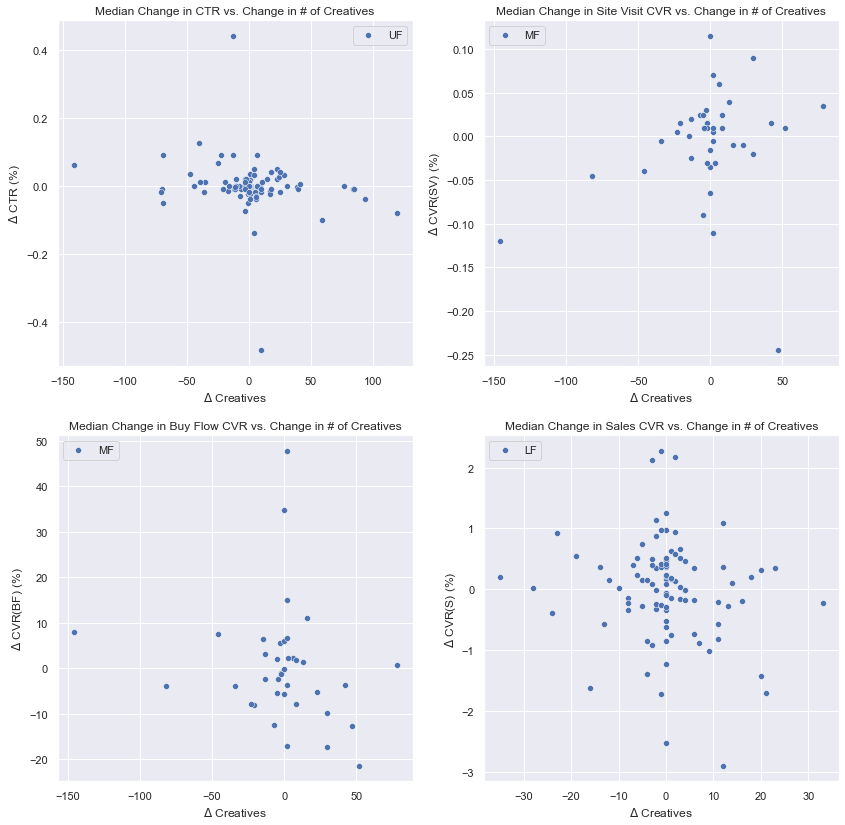

In [105]:
# Plot number of creatives against KPIs
fig, ax = plt.subplots(2, 2, figsize=(14, 14))

# CTR
sns.scatterplot(x='In_Market_UF_Diff', y='Median_CTR_Diff', data=plo_df, label='UF', ax=ax[0,0])
ax[0,0].set_title('Median Change in CTR vs. Change in # of Creatives')
ax[0,0].set_xlabel('$\Delta$ Creatives')
ax[0,0].set_ylabel('$\Delta$ CTR (%)')
ax[0,0].legend()

# Site visit CVR
sns.scatterplot(x='In_Market_MF_Diff', y='Median_Site_Visit_CVR_Diff', data=plo_df, label='MF', ax=ax[0,1])
ax[0,1].set_title('Median Change in Site Visit CVR vs. Change in # of Creatives')
ax[0,1].set_xlabel('$\Delta$ Creatives')
ax[0,1].set_ylabel('$\Delta$ CVR(SV) (%)')
ax[0,1].legend(loc='upper left')

# Buy flow CVR
sns.scatterplot(x='In_Market_MF_Diff', y='Median_Buy_Flow_CVR_Diff', label='MF', data=plo_df, ax=ax[1,0])
ax[1,0].set_title('Median Change in Buy Flow CVR vs. Change in # of Creatives')
ax[1,0].set_xlabel('$\Delta$ Creatives')
ax[1,0].set_ylabel('$\Delta$ CVR(BF) (%)')
ax[1,0].legend(loc='upper left')

# Sales CVR
sns.scatterplot(x='In_Market_LF_Diff', y='Median_Sales_CVR_Diff', data=plo_df, label='LF', ax=ax[1,1])
ax[1,1].set_title('Median Change in Sales CVR vs. Change in # of Creatives')
ax[1,1].set_xlabel('$\Delta$ Creatives')
ax[1,1].set_ylabel('$\Delta$ CVR(S) (%)')
ax[1,1].legend(loc='upper left')

plt.show()

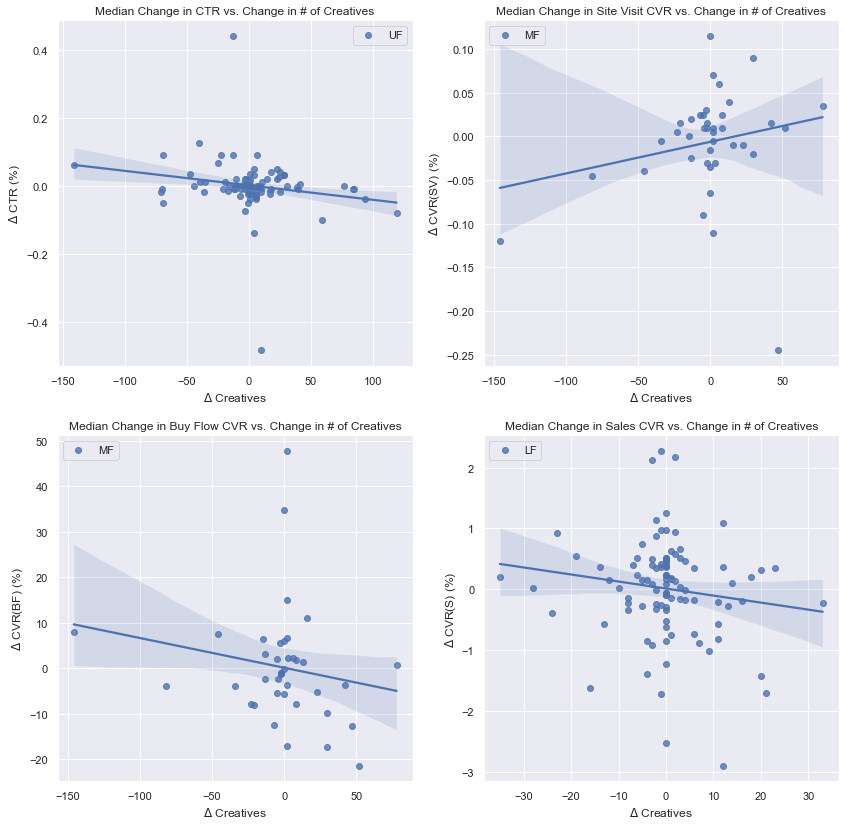

In [106]:
# Plot number of creatives against KPIs
fig, ax = plt.subplots(2, 2, figsize=(14, 14))

# CTR
sns.regplot(x='In_Market_UF_Diff', y='Median_CTR_Diff', data=plo_df, label='UF', ax=ax[0,0])
ax[0,0].set_title('Median Change in CTR vs. Change in # of Creatives')
ax[0,0].set_xlabel('$\Delta$ Creatives')
ax[0,0].set_ylabel('$\Delta$ CTR (%)')
ax[0,0].legend()

# Site visit CVR
sns.regplot(x='In_Market_MF_Diff', y='Median_Site_Visit_CVR_Diff', data=plo_df, label='MF', ax=ax[0,1])
ax[0,1].set_title('Median Change in Site Visit CVR vs. Change in # of Creatives')
ax[0,1].set_xlabel('$\Delta$ Creatives')
ax[0,1].set_ylabel('$\Delta$ CVR(SV) (%)')
ax[0,1].legend(loc='upper left')

# Buy flow CVR
sns.regplot(x='In_Market_MF_Diff', y='Median_Buy_Flow_CVR_Diff', label='MF', data=plo_df, ax=ax[1,0])
ax[1,0].set_title('Median Change in Buy Flow CVR vs. Change in # of Creatives')
ax[1,0].set_xlabel('$\Delta$ Creatives')
ax[1,0].set_ylabel('$\Delta$ CVR(BF) (%)')
ax[1,0].legend(loc='upper left')

# Sales CVR
sns.regplot(x='In_Market_LF_Diff', y='Median_Sales_CVR_Diff', data=plo_df, label='LF', ax=ax[1,1])
ax[1,1].set_title('Median Change in Sales CVR vs. Change in # of Creatives')
ax[1,1].set_xlabel('$\Delta$ Creatives')
ax[1,1].set_ylabel('$\Delta$ CVR(S) (%)')
ax[1,1].legend(loc='upper left')

plt.show()

In [107]:
# Check stationarity in differences and holiday indicator
for col in plo_df.columns[7:]:
    try:
        print(f'{col}: {adfuller(plo_df[col])[1]}')
    except:
        print(f'{col}: {adfuller(plo_df[col].dropna())[1]}')

In_Market_UF_Diff: 2.5434571839153453e-11
In_Market_MF_Diff: 0.0001930661791159552
In_Market_LF_Diff: 8.317358762039783e-14
Median_CTR_Diff: 1.1342404828033694e-29
Median_Buy_Flow_CVR_Diff: 3.354007721996367e-05
Median_Site_Visit_CVR_Diff: 5.073261495945891e-18
Median_Sales_CVR_Diff: 1.327366059991837e-15
is_holiday: 0.0004729877463687426


#### Time series regression assumptions

1. Linear in parameters
2. No perfect collinearity
3. Stationary and weakly dependent
4. Zero conditional mean (contemporaneous)
5. Homoskedasticity
6. No serial correlation (autocorrelation)

**Consistency assumptions**
1. Linear in parameters
2. No perfect collinearity
3. Stationary and weakly dependent
4. Zero conditional mean (contemporaneous)

We believe our estimation equations satisfy the assumptions for a consistent estimator.

$$
\begin{aligned}
&MedCTR^{UF}_t = \beta_0 + \beta_1InMarket^{UF}_t + \beta_2Holiday_t + \epsilon_t \\\\

&MedCVRSV^{MF}_t = \beta_0 + \beta_1InMarket^{MF}_t + \epsilon_t \\\\

&MedCVRBF^{MF}_t = \beta_0 + \beta_1InMarket^{MF}_t + \beta_2Holiday_t + \epsilon_t \\\\

&MedCVRS^{LF}_t = \beta_0 + \beta_1InMarket^{LF}_t + \epsilon_t \\\\
\end{aligned}
$$

                            OLS Regression Results                            
Dep. Variable:        Median_CTR_Diff   R-squared:                       0.076
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     4.050
Date:                Wed, 27 Apr 2022   Prob (F-statistic):             0.0204
Time:                        18:10:44   Log-Likelihood:                 122.77
No. Observations:                 101   AIC:                            -239.5
Df Residuals:                      98   BIC:                            -231.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0053      0.00

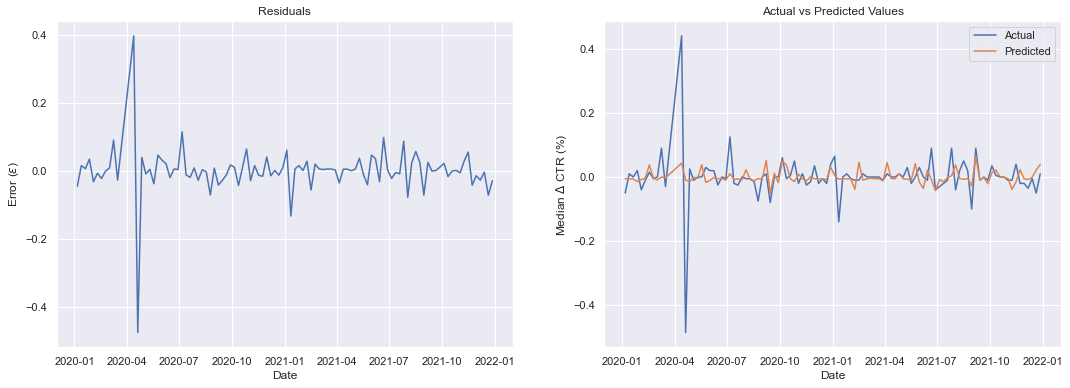

In [108]:
X_vars = ['In_Market_UF_Diff', 'is_holiday']

X = plo_df[X_vars].dropna()
y = plo_df['Median_CTR_Diff'].dropna()

X = sm.add_constant(X)

reg = sm.OLS(y, X).fit()
print(reg.summary())

# Plot residuals and actual vs fitted values
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

ax[0].plot(reg.resid)
ax[0].set_title('Residuals')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Error ($\epsilon$)')

ax[1].plot(plo_df['Median_CTR_Diff'], label='Actual')
ax[1].plot(reg.fittedvalues, label='Predicted')
ax[1].set_title('Actual vs Predicted Values')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Median $\Delta$ CTR (%)')

ax[1].legend()
plt.show()

The regression coefficient on `In_Market_UF_Diff` says that, on average, adding one more upper funnel creatives relates to a median CTR decrease of 0.0004 percent, all else constant. The coefficient estimate is quite small so there is not much of an effect.

                                OLS Regression Results                                
Dep. Variable:     Median_Site_Visit_CVR_Diff   R-squared:                       0.045
Model:                                    OLS   Adj. R-squared:                  0.019
Method:                         Least Squares   F-statistic:                     1.732
Date:                        Wed, 27 Apr 2022   Prob (F-statistic):              0.196
Time:                                18:10:44   Log-Likelihood:                 55.012
No. Observations:                          39   AIC:                            -106.0
Df Residuals:                              37   BIC:                            -102.7
Df Model:                                   1                                         
Covariance Type:                    nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------

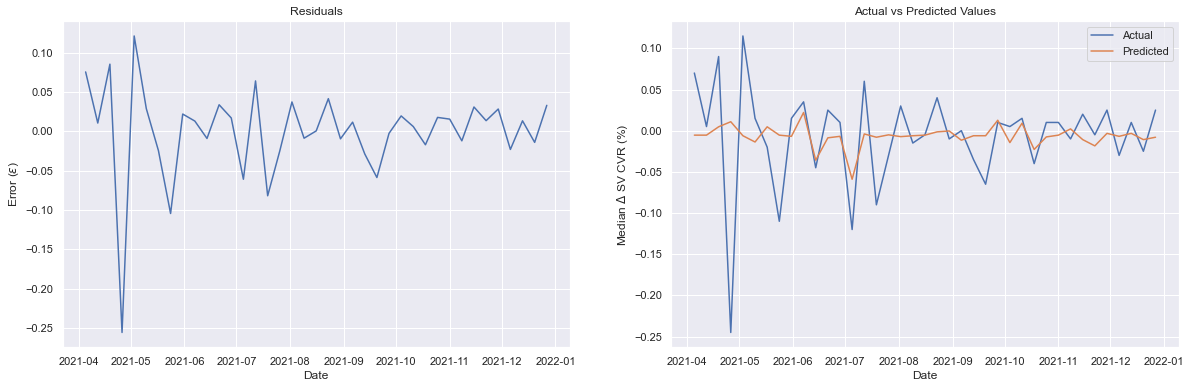

In [109]:
# Regression
X_vars = ['In_Market_MF_Diff']

X = plo_df[X_vars].loc['2021-04-05':]
y = plo_df['Median_Site_Visit_CVR_Diff'].dropna()

X = sm.add_constant(X)

reg = sm.OLS(y, X).fit()
print(reg.summary())

# Plot residuals and actual vs fitted values
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

ax[0].plot(reg.resid)
ax[0].set_title('Residuals')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Error ($\epsilon$)')

ax[1].plot(plo_df['Median_Site_Visit_CVR_Diff'], label='Actual')
ax[1].plot(reg.fittedvalues, label='Predicted')
ax[1].set_title('Actual vs Predicted Values')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Median $\Delta$ SV CVR (%)')

ax[1].legend()
plt.show()

The coefficient for `In_Market_MF_Diff` says, on average, adding one more middle funnel creatives relates to a median SV CVR increase of 0.0004 percent, all else constant. The coefficient estimate is quite small so there is not much of an effect.

                               OLS Regression Results                               
Dep. Variable:     Median_Buy_Flow_CVR_Diff   R-squared:                       0.092
Model:                                  OLS   Adj. R-squared:                  0.042
Method:                       Least Squares   F-statistic:                     1.831
Date:                      Wed, 27 Apr 2022   Prob (F-statistic):              0.175
Time:                              18:10:44   Log-Likelihood:                -151.53
No. Observations:                        39   AIC:                             309.1
Df Residuals:                            36   BIC:                             314.1
Df Model:                                 2                                         
Covariance Type:                  nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------

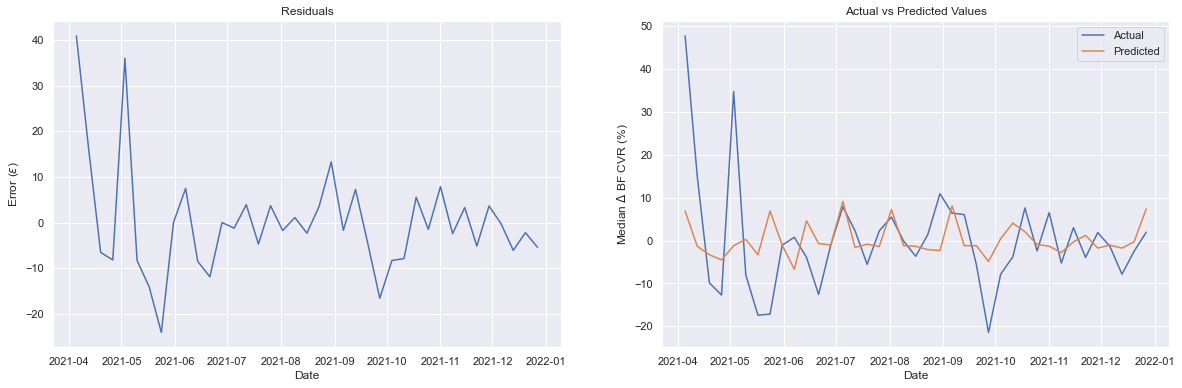

In [110]:
X_vars = ['In_Market_MF_Diff', 'is_holiday']

X = plo_df[X_vars].loc['2021-04-05':]
y = plo_df['Median_Buy_Flow_CVR_Diff'].dropna()

X = sm.add_constant(X)

reg = sm.OLS(y, X).fit()
print(reg.summary())

# Plot residuals and actual vs fitted values
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

ax[0].plot(reg.resid)
ax[0].set_title('Residuals')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Error ($\epsilon$)')

ax[1].plot(plo_df['Median_Buy_Flow_CVR_Diff'], label='Actual')
ax[1].plot(reg.fittedvalues, label='Predicted')
ax[1].set_title('Actual vs Predicted Values')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Median $\Delta$ BF CVR (%)')

ax[1].legend()
plt.show()

The `In_Market_MF_Diff` coefficient states that, on average, adding one more middle funnel creative relates to a median BF CVR decrease of 0.071 percent, all else constant.

                              OLS Regression Results                             
Dep. Variable:     Median_Sales_CVR_Diff   R-squared:                       0.020
Model:                               OLS   Adj. R-squared:                  0.010
Method:                    Least Squares   F-statistic:                     1.993
Date:                   Wed, 27 Apr 2022   Prob (F-statistic):              0.161
Time:                           18:10:44   Log-Likelihood:                -121.07
No. Observations:                    101   AIC:                             246.1
Df Residuals:                         99   BIC:                             251.4
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const   

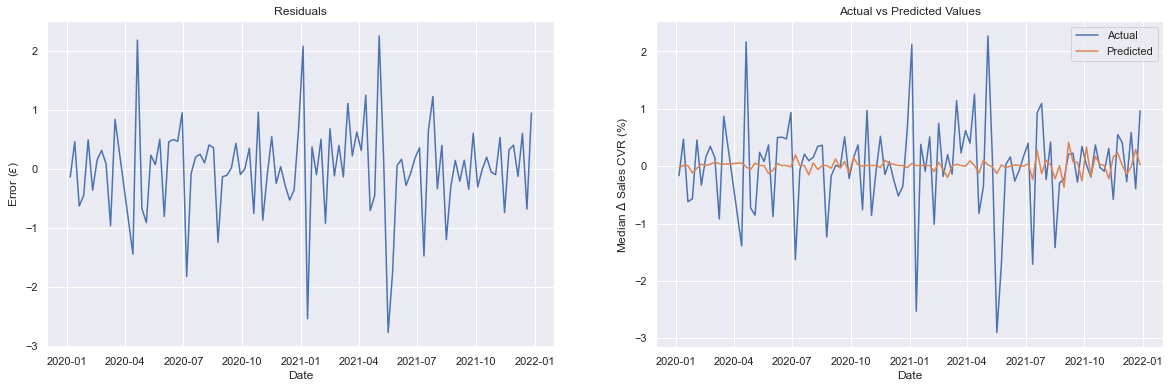

In [111]:
X_vars = ['In_Market_LF_Diff']

X = plo_df[X_vars].dropna()
y = plo_df['Median_Sales_CVR_Diff'].dropna()

X = sm.add_constant(X)

reg = sm.OLS(y, X).fit()
print(reg.summary())

# Plot residuals and actual vs fitted values
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

ax[0].plot(reg.resid)
ax[0].set_title('Residuals')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Error ($\epsilon$)')

ax[1].plot(plo_df['Median_Sales_CVR_Diff'], label='Actual')
ax[1].plot(reg.fittedvalues, label='Predicted')
ax[1].set_title('Actual vs Predicted Values')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Median $\Delta$ Sales CVR (%)')

ax[1].legend()
plt.show()

On average, adding one more lower funnel creatives relates to a median Sales CVR decrease of 0.012 percent.

## Additional Analysis

### What's the average KPI behaviour after launch?

In [112]:
week_data.fillna(0, inplace=True)

# Plot weekly means
ctr_means = week_data[ctr_w].mean().values
cvrbf_means = week_data[cvrbf_w].mean().values
cvrsv_means = week_data[cvrsv_w].mean().values
cvrint_means = week_data[cvrint_w].mean().values

kpis = pd.DataFrame(
    {'Avg CTR': ctr_means,
    'Avg Site Visit CVR': cvrsv_means,
    'Avg Buy Flow CVR': cvrbf_means,
    'Avg Sales CVR': cvrint_means}
)
kpis.head()

,Avg CTR,Avg Site Visit CVR,Avg Buy Flow CVR,Avg Sales CVR
0,0.374186,0.140441,39.272953,0.429555
1,0.357175,0.145592,52.604816,0.585678
2,0.344800,0.136816,46.170140,0.562004
3,0.292899,0.122841,44.055353,0.514986
4,0.202293,0.078685,35.272214,0.455427


In [113]:
kpis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Avg CTR             41 non-null     float64
 1   Avg Site Visit CVR  41 non-null     float64
 2   Avg Buy Flow CVR    41 non-null     float64
 3   Avg Sales CVR       41 non-null     float64
dtypes: float64(4)
memory usage: 1.4 KB


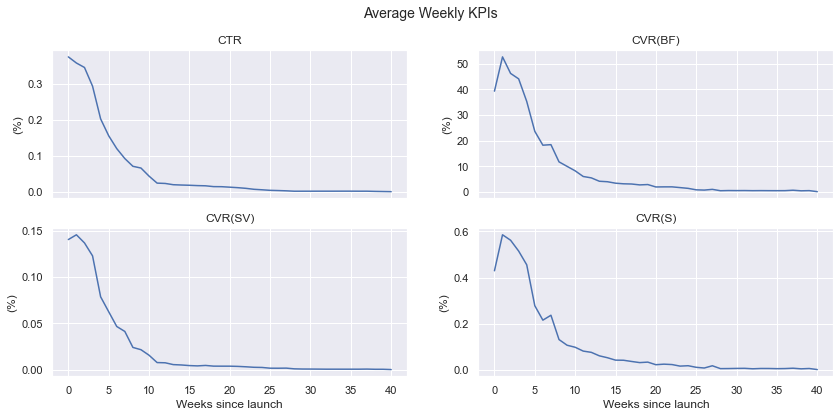

In [114]:
fig, ax = plt.subplots(2, 2, figsize=(14, 6), sharex=True)
fig.suptitle('Average Weekly KPIs', fontsize=14)

sns.lineplot(x=range(41), y='Avg CTR', data=kpis, ax=ax[0,0])
ax[0,0].set_title('CTR')
ax[0,0].set_xlabel('Weeks since launch')
ax[0,0].set_ylabel('(%)')

sns.lineplot(x=range(41), y='Avg Site Visit CVR', data=kpis, ax=ax[1,0])
ax[1,0].set_title('CVR(SV)')
ax[1,0].set_xlabel('Weeks since launch')
ax[1,0].set_ylabel('(%)')

sns.lineplot(x=range(41), y='Avg Buy Flow CVR', data=kpis, ax=ax[0,1])
ax[0,1].set_title('CVR(BF)')
ax[0,1].set_xlabel('Weeks since launch')
ax[0,1].set_ylabel('(%)')

sns.lineplot(x=range(41), y='Avg Sales CVR', data=kpis, ax=ax[1,1])
ax[1,1].set_title('CVR(S)')
ax[1,1].set_xlabel('Weeks since launch')
ax[1,1].set_ylabel('(%)')

plt.show()

CTRs fall immediately upon launch, whereas BF, SV, and sales increases for a short period. This behaviour seems normal since some people may visit the website but not necessarily by clicking on the creative ad itself. We also see that a creatives life cycle begins to end near week 10 where the "elbow" or "kink" is located.

### What's the effect of spending and in market creatives on performance?

In [115]:
# Create week features for in market creatives
for week in raw_spend_imp[:102]:
    date = week[:-5]  # Remove "Spend"
    date += 'In Market'

    social_data_plo1[date] = social_data_plo1[week].apply(lambda x: 1 if x > 0 else 0)

in_market_w = [col for col in social_data_plo1.columns if col.endswith('In Market')]
social_data_plo1.fillna(0, inplace=True)
social_data_plo1.head()

,Creative ID,funnel,publisher,lob,product,theme,kpi_audience,creative_versions,price,price_placement,discount,offer_placement,offer_group,asset_type,video_type,length,2019-12-30-Spend,2020-1-6-Spend,2020-1-13-Spend,2020-1-20-Spend,2020-1-27-Spend,2020-2-3-Spend,2020-2-10-Spend,2020-2-17-Spend,2020-2-24-Spend,2020-3-2-Spend,2020-3-9-Spend,2020-3-16-Spend,2020-4-13-Spend,2020-4-20-Spend,2020-4-27-Spend,2020-5-4-Spend,2020-5-11-Spend,2020-5-18-Spend,2020-5-25-Spend,2020-6-1-Spend,2020-6-8-Spend,2020-6-15-Spend,2020-6-22-Spend,2020-6-29-Spend,2020-7-6-Spend,2020-7-13-Spend,2020-7-20-Spend,2020-7-27-Spend,2020-8-3-Spend,2020-8-10-Spend,2020-8-17-Spend,2020-8-24-Spend,2020-8-31-Spend,2020-9-7-Spend,2020-9-14-Spend,2020-9-21-Spend,2020-9-28-Spend,2020-10-5-Spend,2020-10-12-Spend,2020-10-19-Spend,2020-10-26-Spend,2020-11-2-Spend,2020-11-9-Spend,2020-11-16-Spend,2020-11-23-Spend,2020-11-30-Spend,2020-12-7-Spend,2020-12-14-Spend,2020-12-21-Spend,2020-12-28-Spend,2021-1-4-Spend,2021-1-11-Spend,2021-1-18-Spend,2021-1-25-Spend,2021-2-1-Spend,2021-2-8-Spend,2021-2-15-Spend,2021-2-22-Spend,2021-3-1-Spend,2021-3-8-Spend,2021-3-15-Spend,2021-3-22-Spend,2021-3-29-Spend,2021-4-5-Spend,2021-4-12-Spend,2021-4-19-Spend,2021-4-26-Spend,2021-5-3-Spend,2021-5-10-Spend,2021-5-17-Spend,2021-5-24-Spend,2021-5-31-Spend,2021-6-7-Spend,2021-6-14-Spend,2021-6-21-Spend,2021-6-28-Spend,2021-7-5-Spend,2021-7-12-Spend,2021-7-19-Spend,2021-7-26-Spend,2021-8-2-Spend,2021-8-9-Spend,2021-8-16-Spend,2021-8-23-Spend,2021-8-30-Spend,2021-9-6-Spend,2021-9-13-Spend,2021-9-20-Spend,2021-9-27-Spend,2021-10-4-Spend,2021-10-11-Spend,2021-10-18-Spend,2021-10-25-Spend,2021-11-1-Spend,2021-11-8-Spend,2021-11-15-Spend,2021-11-22-Spend,2021-11-29-Spend,2021-12-6-Spend,2021-12-13-Spend,2021-12-20-Spend,2021-12-27-Spend,2019-12-30-Impressions,2020-1-6-Impressions,2020-1-13-Impressions,2020-1-20-Impressions,2020-1-27-Impressions,2020-2-3-Impressions,2020-2-10-Impressions,2020-2-17-Impressions,2020-2-24-Impressions,2020-3-2-Impressions,2020-3-9-Impressions,2020-3-16-Impressions,2020-4-13-Impressions,2020-4-20-Impressions,2020-4-27-Impressions,2020-5-4-Impressions,2020-5-11-Impressions,2020-5-18-Impressions,2020-5-25-Impressions,2020-6-1-Impressions,2020-6-8-Impressions,2020-6-15-Impressions,2020-6-22-Impressions,2020-6-29-Impressions,2020-7-6-Impressions,2020-7-13-Impressions,2020-7-20-Impressions,2020-7-27-Impressions,2020-8-3-Impressions,2020-8-10-Impressions,2020-8-17-Impressions,2020-8-24-Impressions,2020-8-31-Impressions,2020-9-7-Impressions,2020-9-14-Impressions,2020-9-21-Impressions,2020-9-28-Impressions,2020-10-5-Impressions,2020-10-12-Impressions,2020-10-19-Impressions,2020-10-26-Impressions,2020-11-2-Impressions,2020-11-9-Impressions,2020-11-16-Impressions,2020-11-23-Impressions,2020-11-30-Impressions,2020-12-7-Impressions,2020-12-14-Impressions,2020-12-21-Impressions,2020-12-28-Impressions,2021-1-4-Impressions,2021-1-11-Impressions,2021-1-18-Impressions,2021-1-25-Impressions,2021-2-1-Impressions,2021-2-8-Impressions,2021-2-15-Impressions,2021-2-22-Impressions,2021-3-1-Impressions,2021-3-8-Impressions,2021-3-15-Impressions,2021-3-22-Impressions,2021-3-29-Impressions,2021-4-5-Impressions,2021-4-12-Impressions,2021-4-19-Impressions,2021-4-26-Impressions,2021-5-3-Impressions,2021-5-10-Impressions,2021-5-17-Impressions,2021-5-24-Impressions,2021-5-31-Impressions,2021-6-7-Impressions,2021-6-14-Impressions,2021-6-21-Impressions,2021-6-28-Impressions,2021-7-5-Impressions,2021-7-12-Impressions,2021-7-19-Impressions,2021-7-26-Impressions,2021-8-2-Impressions,2021-8-9-Impressions,2021-8-16-Impressions,2021-8-23-Impressions,2021-8-30-Impressions,2021-9-6-Impressions,2021-9-13-Impressions,2021-9-20-Impressions,2021-9-27-Impressions,2021-10-4-Impressions,2021-10-11-Impressions,2021-10-18-Impressions,2021-10-25-Impressions,2021-11-1-Impressions,2021-11-8-Impressions,2021-11-15-Impressions,2021-11-22-Impressions,2021-11-29-Impressions,2021-12-6-Impressions,2021-12-13-Impressions,2021-12-2

Since we'll be grouping by publisher, we can remove the publishers with low occurrence.

In [116]:
# Remove low observations of publishers
publishers = ['Publisher 3', 'Publisher 4', 'Publisher 5']
publishers345 = social_data_plo1[social_data_plo1['publisher'].isin(publishers)]

In [120]:
groups = ['funnel', 'publisher']
dates = pd.DatetimeIndex(dates)
spend_w = raw_spend_imp[:102]

# Timeline of creatives in market, total spending and avg KPIs per funnel and publisher
in_market_agg = publishers345.pivot_table(values=in_market_w, columns=groups, aggfunc='sum').set_index(dates).resample('M').sum()
spending_agg = publishers345.pivot_table(values=spend_w, columns=groups, aggfunc='sum').set_index(dates).resample('M').sum()
ctr_agg = publishers345.pivot_table(values=raw_ctr, columns=groups, aggfunc='mean').set_index(dates).resample('M').mean()
cvrsv_agg = publishers345.pivot_table(values=raw_cvrsv, columns=groups, aggfunc='mean').set_index(dates).resample('M').mean()
cvrbf_agg = publishers345.pivot_table(values=raw_cvrbf, columns=groups, aggfunc='mean').set_index(dates).resample('M').mean()
cvrs_agg = publishers345.pivot_table(values=raw_cvrs, columns=groups, aggfunc='mean').set_index(dates).resample('M').mean()

ctr_agg.loc[:, 'UF'].head()

publisher,Publisher 3,Publisher 4,Publisher 5
2019-12-31,0.000846,0.001186,0.000000
2020-01-31,0.001907,0.002408,0.000000
2020-02-29,0.002388,0.009110,0.000000
2020-03-31,0.001526,0.005269,0.000000
2020-04-30,0.001266,0.004260,0.000064


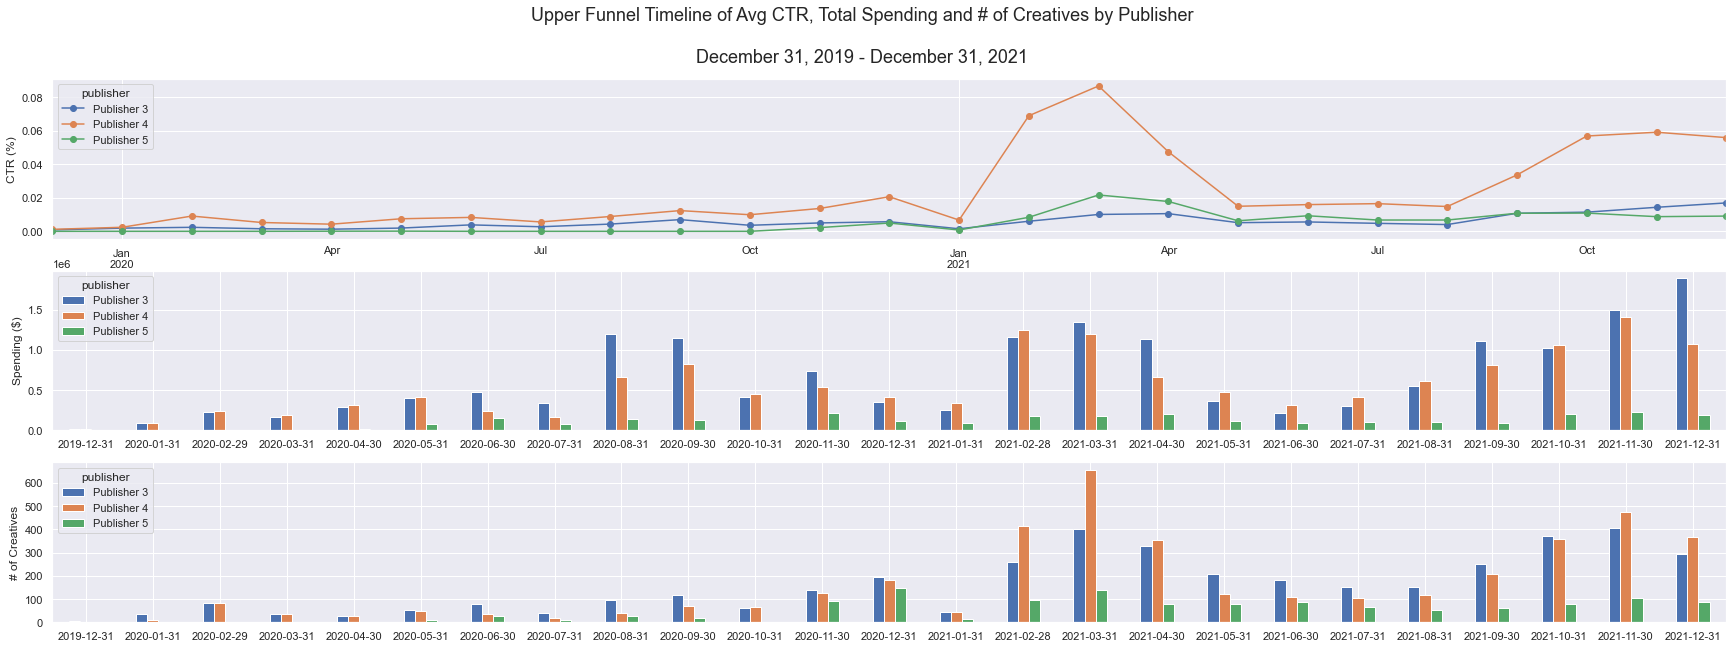

In [121]:
# Plot upper funnel CTR and creatives in market
fig, ax = plt.subplots(3, figsize=(30, 10))
fig.suptitle('Upper Funnel Timeline of Avg CTR, Total Spending and # of Creatives by Publisher\n\nDecember 31, 2019 - December 31, 2021', fontsize=18)

# CTR
ctr_agg.loc[:, 'UF'].plot(style='o-', ax=ax[0])
ax[0].set_ylabel('CTR (%)')

# Spending
spending_agg.loc[:, 'UF'].plot(kind='bar', ax=ax[1])
ax[1].set_xticklabels(spending_agg.index.date, rotation=0)
ax[1].set_ylabel('Spending ($)')

# Creatives in market
in_market_agg.loc[:, 'UF'].plot(kind='bar', ax=ax[2])
ax[2].set_xticklabels(in_market_agg.index.date, rotation=0)
ax[2].set_ylabel('# of Creatives')

plt.show()

Upper funnel creatives served in publisher 4 yield greater average CTRs than creatives served in publisher 3. There seems to be some ROI from money spent on publisher 4, but money spent on creatives in publisher 3 seem to have no affect on CTRs. There is not enough data before January 31, 2021 to conclude anything significant.

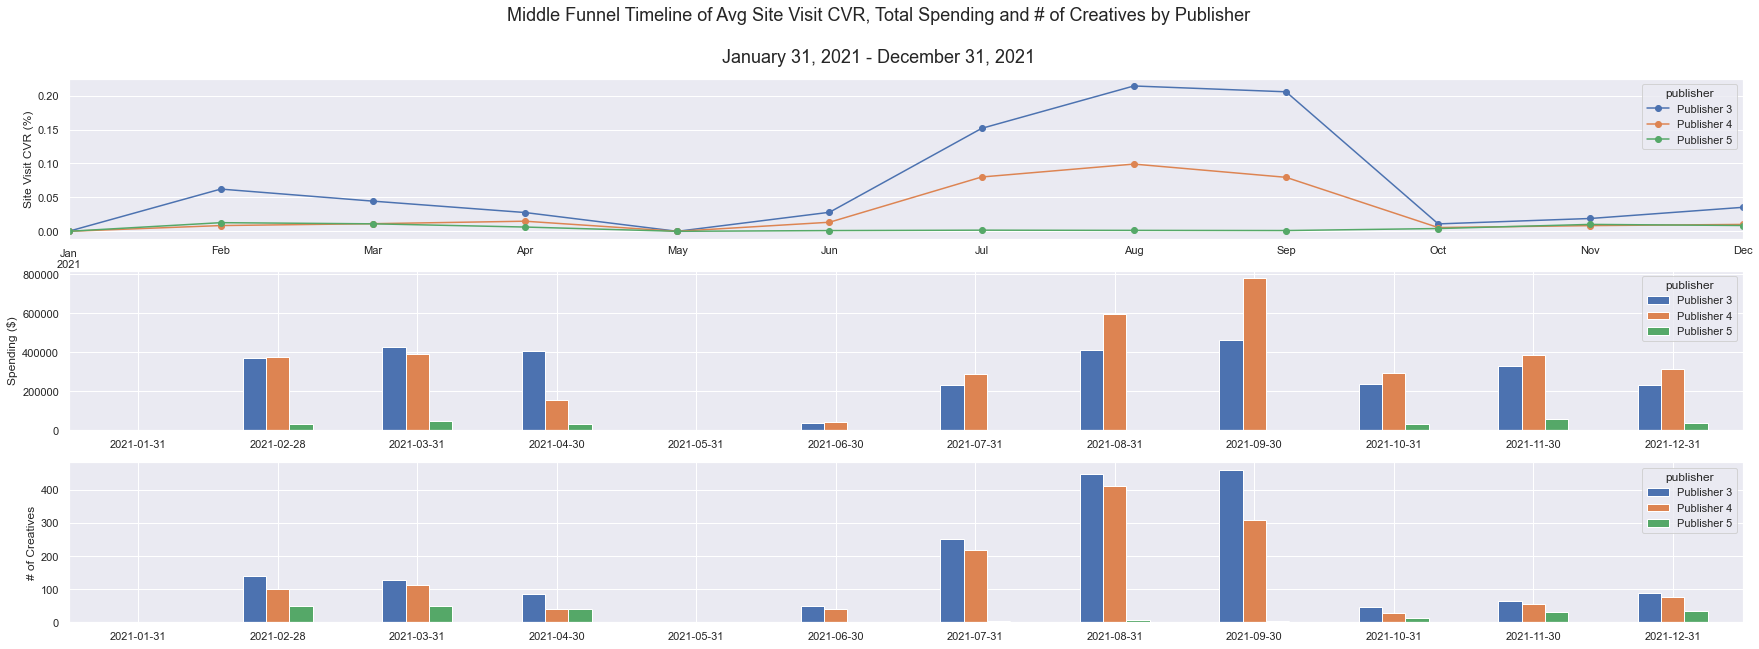

In [122]:
# Plot upper funnel Site Visit CVR and creatives in market
fig, ax = plt.subplots(3, figsize=(30, 10))
fig.suptitle('Middle Funnel Timeline of Avg Site Visit CVR, Total Spending and # of Creatives by Publisher\n\nJanuary 31, 2021 - December 31, 2021', fontsize=18)

# SV CVR
cvrsv_agg.loc['2021-01-31':, 'MF'].plot(style='o-', ax=ax[0])
ax[0].set_ylabel('Site Visit CVR (%)')

# Spending
spending_agg.loc['2021-01-31':, 'MF'].plot(kind='bar', ax=ax[1])
ax[1].set_xticklabels(spending_agg.loc['2021-01-31':].index.date, rotation=0)
ax[1].set_ylabel('Spending ($)')

# Creatives in market
in_market_agg.loc['2021-01-31':, 'MF'].plot(kind='bar', ax=ax[2])
ax[2].set_xticklabels(in_market_agg.loc['2021-01-31':].index.date, rotation=0)
ax[2].set_ylabel('# of Creatives')

plt.show()

Middle funnel creatives served in publisher 3 yield higher average site visit conversion rates than creatives served in publisher 4. Publisher 4 creatives seem to have low ROI compared to publisher 3 creatives.

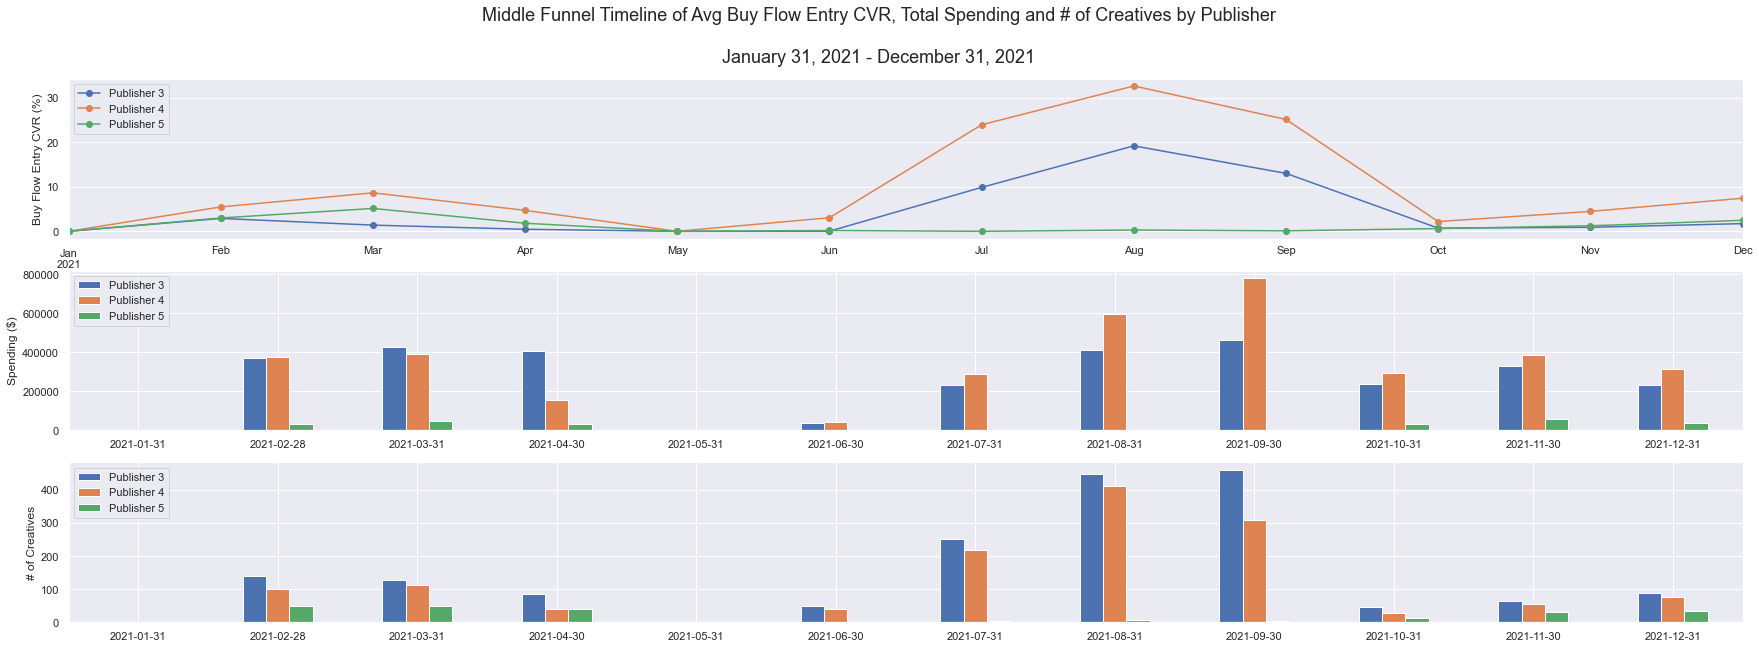

In [123]:
# Plot middle funnel buy flow entry CVR and creatives in market
fig, ax = plt.subplots(3, figsize=(30, 10))
fig.suptitle('Middle Funnel Timeline of Avg Buy Flow Entry CVR, Total Spending and # of Creatives by Publisher\n\nJanuary 31, 2021 - December 31, 2021', fontsize=18)

# BF CVR
cvrbf_agg.loc['2021-01-31':, 'MF'].plot(style='o-', ax=ax[0])
ax[0].set_ylabel('Buy Flow Entry CVR (%)')
ax[0].legend(loc='upper left')

# Spending
spending_agg.loc['2021-01-31':, 'MF'].plot(kind='bar', ax=ax[1])
ax[1].set_xticklabels(spending_agg.loc['2021-01-31':].index.date, rotation=0)
ax[1].set_ylabel('Spending ($)')
ax[1].legend(loc='upper left')

# Creatives in market
in_market_agg.loc['2021-01-31':, 'MF'].plot(kind='bar', ax=ax[2])
ax[2].set_xticklabels(in_market_agg.loc['2021-01-31':].index.date, rotation=0)
ax[2].set_ylabel('# of Creatives')
ax[2].legend(loc='upper left')

plt.show()

Middle funnel creatives served in publisher 4 yield higher average buy flow conversion rates than creatives served in publisher 3. It's difficult to tell if money spent has any affect since publisher 3 and 4 creatives follow a similar CVR pattern.

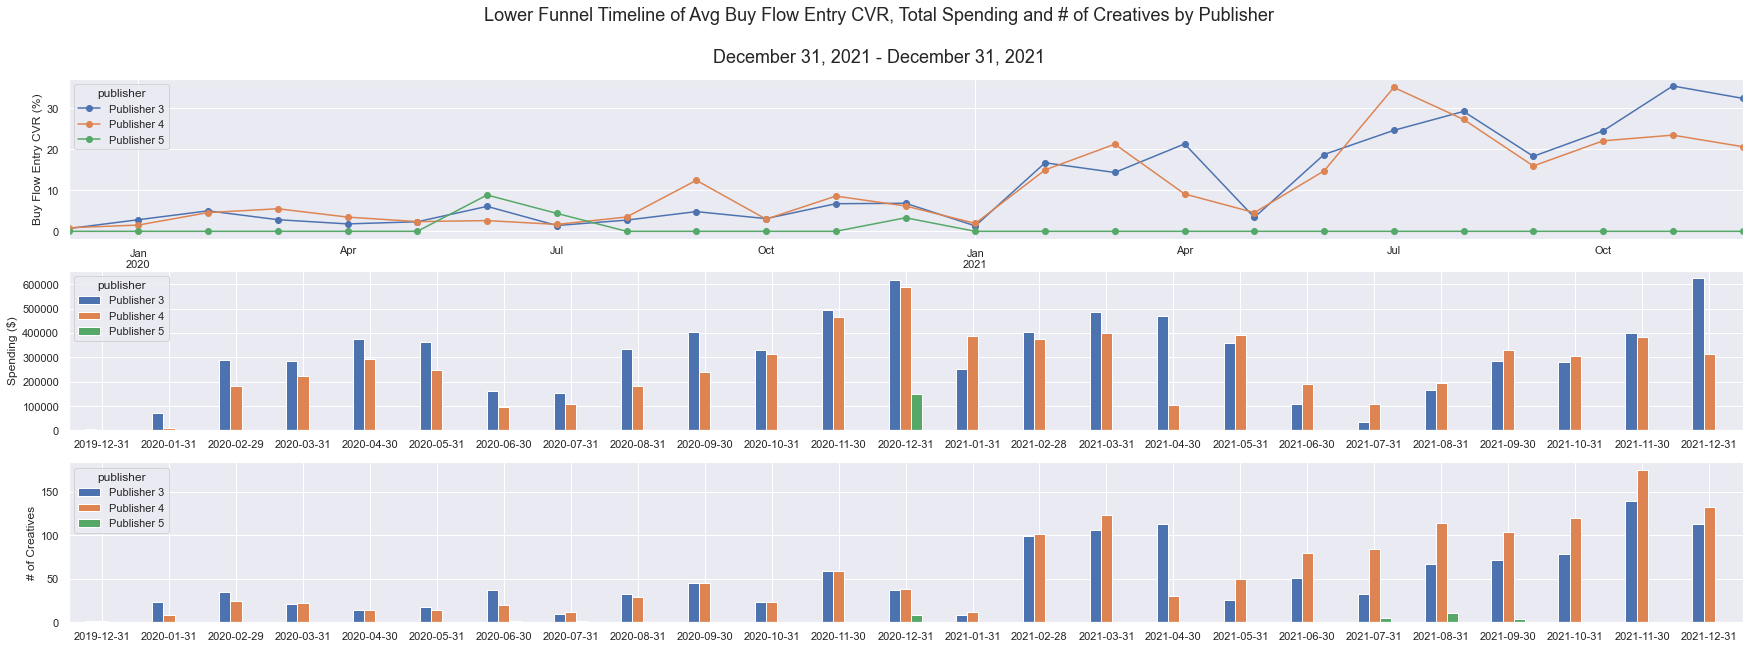

In [124]:
# Plot lower funnel buy flow entry CVR and creatives in market
fig, ax = plt.subplots(3, figsize=(30, 10))
fig.suptitle('Lower Funnel Timeline of Avg Buy Flow Entry CVR, Total Spending and # of Creatives by Publisher\n\nDecember 31, 2021 - December 31, 2021', fontsize=18)

# BF CVR
cvrbf_agg.loc[:, 'LF'].plot(style='o-', ax=ax[0])
ax[0].set_ylabel('Buy Flow Entry CVR (%)')

# Spending
spending_agg.loc[:, 'LF'].plot(kind='bar', ax=ax[1])
ax[1].set_xticklabels(spending_agg.index.date, rotation=0)
ax[1].set_ylabel('Spending ($)')

# Creatives in market
in_market_agg.loc[:, 'LF'].plot(kind='bar', ax=ax[2])
ax[2].set_xticklabels(in_market_agg.index.date, rotation=0)
ax[2].set_ylabel('# of Creatives')

plt.show()

Lower funnel creatives served in publisher 3 yield higher average buy flow entry CVRs than creatives served in publisher 4. Comparing spending and CVRs before January 31, 2021, it seems that spending has no affect on buy flow CVRs.

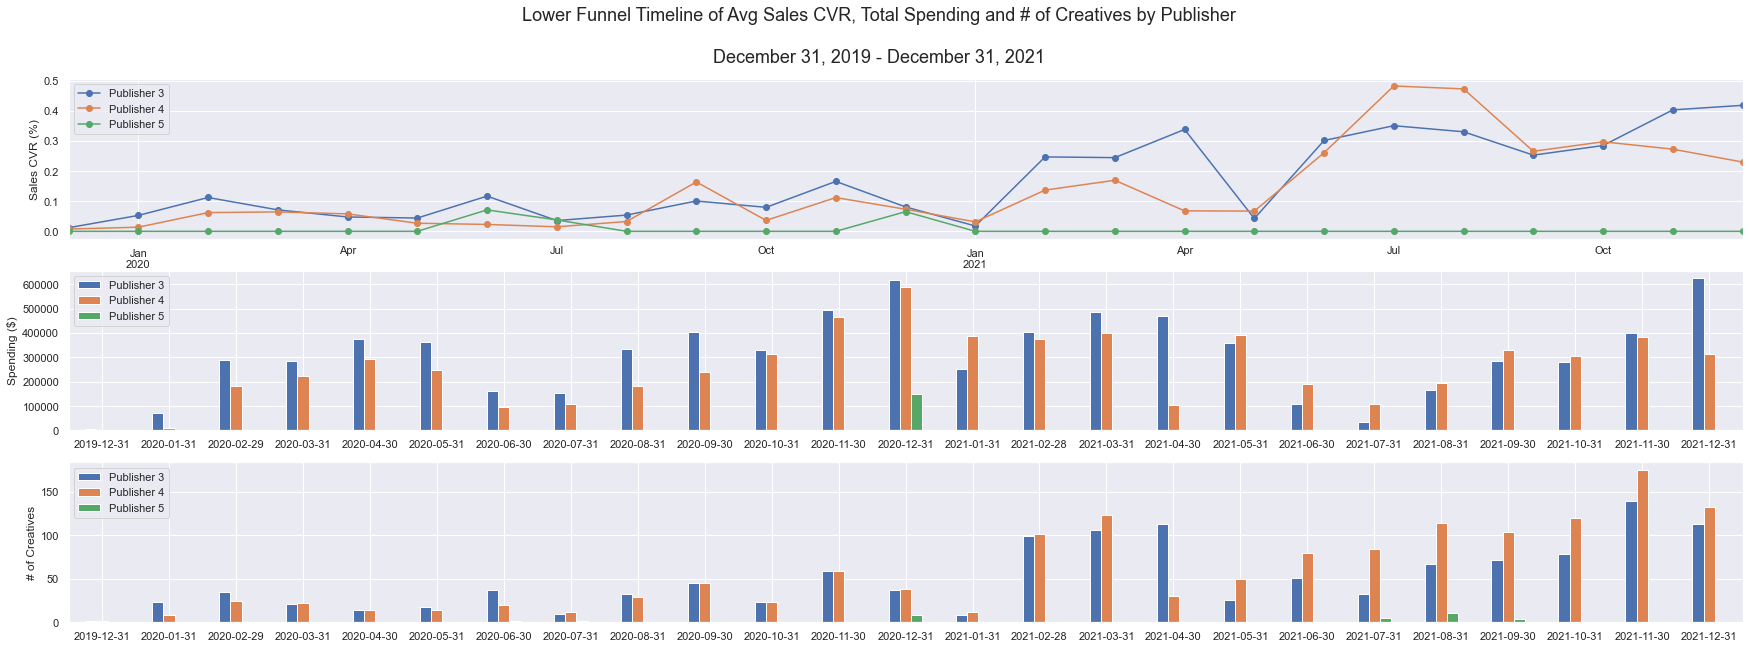

In [125]:
# Plot lower funnel sales CVR and creatives in market
fig, ax = plt.subplots(3, figsize=(30, 10))
fig.suptitle('Lower Funnel Timeline of Avg Sales CVR, Total Spending and # of Creatives by Publisher\n\nDecember 31, 2019 - December 31, 2021', fontsize=18)

# Sales CVR
cvrs_agg.loc[:, 'LF'].plot(style='o-', ax=ax[0])
ax[0].set_ylabel('Sales CVR (%)')
ax[0].legend(loc='upper left')

# Spending
spending_agg.loc[:, 'LF'].plot(kind='bar', ax=ax[1])
ax[1].set_xticklabels(spending_agg.index.date, rotation=0)
ax[1].set_ylabel('Spending ($)')
ax[1].legend(loc='upper left')

# Creatives in market
in_market_agg.loc[:, 'LF'].plot(kind='bar', ax=ax[2])
ax[2].set_xticklabels(in_market_agg.index.date, rotation=0)
ax[2].set_ylabel('# of Creatives')
ax[2].legend(loc='upper left')

plt.show()

Lower funnel creatives served in publisher 3 yield higher average sales conversion rates than creatives served in publisher 4. Again, comparing spending and CVRs before January 31, 2021, it seems that spending has no affect on sales CVRs.